## Load and clean data 

In [1]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data
from tf_chpvk_pv.dataset import get_perovskite_data_NOMAD

get_perovskite_data_NOMAD(False)

2026-02-08 22:01:29.299 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


Importing existing data... with size: (51123, 3)


In [2]:
df = get_raw_data()
print('Data size:', df.shape)
df.head()


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
Data size: (50661, 4)


reduced_formulas descriptive_formulas  bandgap source
0         CH6I3NPb               MAPbI3      1.6    pvk
2         CH6I3NPb               MAPbI3      1.5    pvk
3         CH6I3NPb               MAPbI3      1.6    pvk
4         CH6I3NPb               MAPbI3      1.6    pvk
5         CH6I3NPb               MAPbI3      1.6    pvk

### Group Repeated Formulas

The dataset contains many repeated formulas and corresponding bandgap values. To make sure each formula is unique, we will use the `groupby_formula` function from CrabNet to group entries by their formulas and use the mean values for their bandgap. We make a new final DataFrame for our model, call it **df_reduced_formula** and adjust colum names etc.

Let's rename columns and use the `gourpby_formula` function from CrabNet:

In [3]:
from crabnet.utils.data import groupby_formula  # type: ignore
from tf_chpvk_pv.modeling.CrabNet.utils import save_processed_data
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df.rename(columns={'bandgap': 'target'}, inplace=True)
df.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df, how='median')
df_grouped_formula.head()

save_processed_data(df_grouped_formula)

2026-02-08 21:52:47.104 | INFO     | tf_chpvk_pv.modeling.CrabNet.utils:save_processed_data:77 - Processed data saved to /home/dagar/TF-ChPVK-PV/data/interim/df_grouped_formula_complete_dataset.csv


Let's check the shape of the DataFrame we would like to use for our ML:

In [4]:
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df.loc[df['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalcogenides', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.4f} % from chalcogenides perovskites,' \
      '\n{2:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

The shape of the DataFrame is:  (3628, 3)
After cleaning and groupin the data, the sources percentages are:
43.52 % from halide perovskites,
0.3032 % from chalcogenides perovskites,
56.17 % from chalcogenide semiconductors


### Pettifor features

Let's add the pettifor features based on the grouped_formula to improve the training process. This function already separates the data in 3, being 80% for training, 10% for validation and 10% for test. This separation is done taking into account the source imbalance by stratifyng based on this feature.

In [7]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

### Check Element Prevalence 

We will use `pymatviz` ([link to docs](https://pymatviz.janosh.dev/)) for visualizing the element prevalence.

<Axes: >

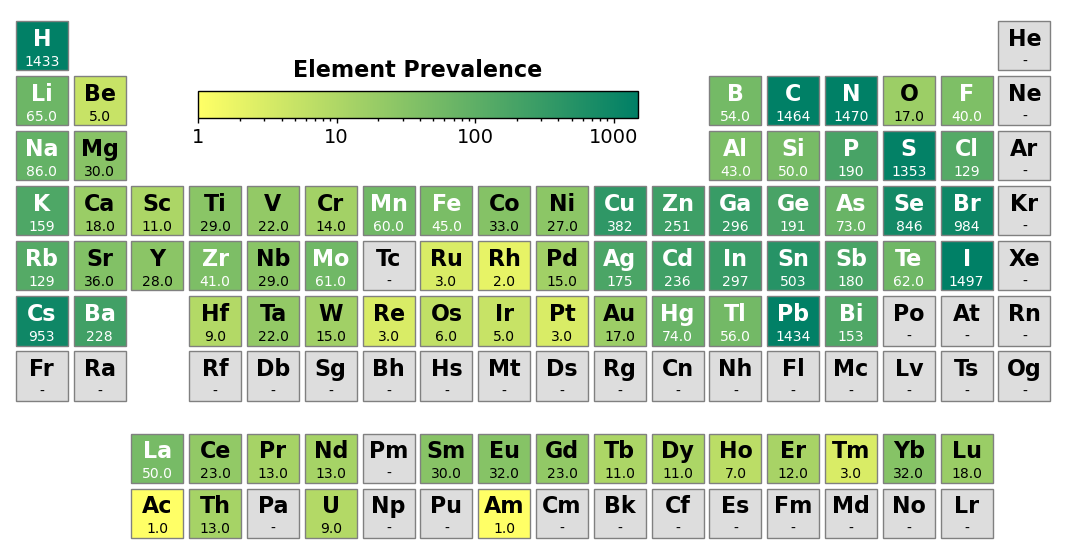

In [8]:
from pymatviz import count_elements, ptable_heatmap
import re

element_counts = count_elements([re.sub(r'\d+', '', x).replace('.', '') for x in df_grouped_formula['formula']])

# Plot the periodic table heatmap
ptable_heatmap(element_counts, log=True, cbar_title='Element Prevalence')

Let's continue and build the model in the next section!

## Build and Fit the Model 

We then fit the model using the CrabNet implementation.


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 142639.66formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 229055.57formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


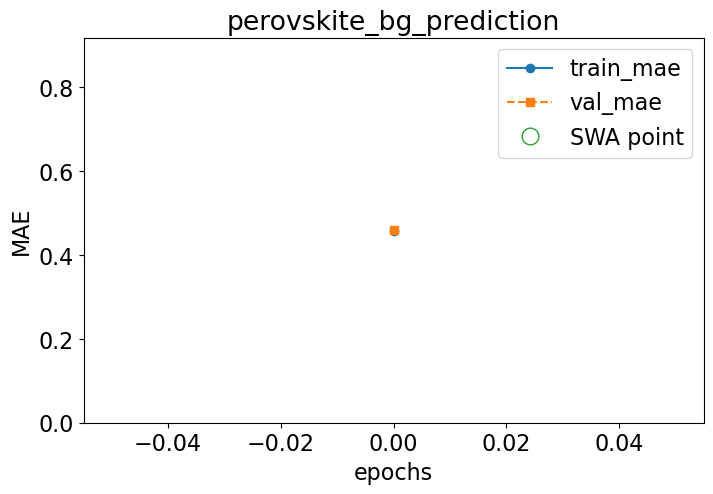

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


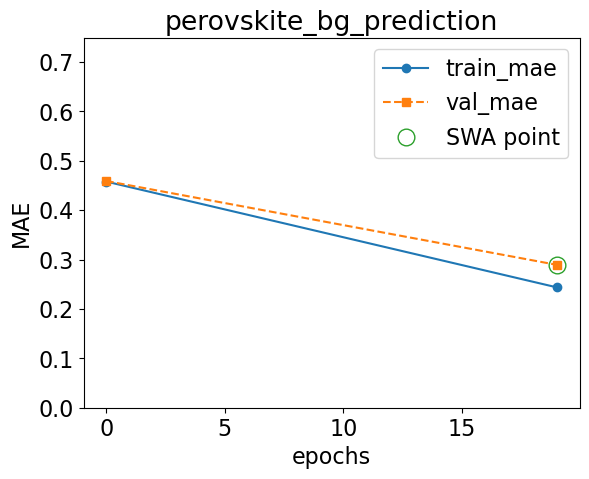

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


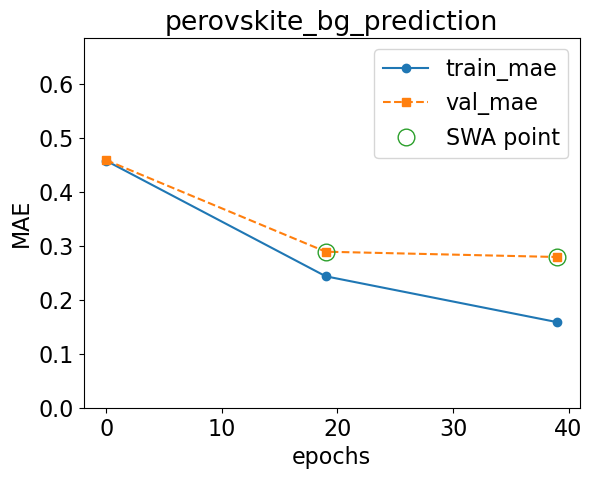

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


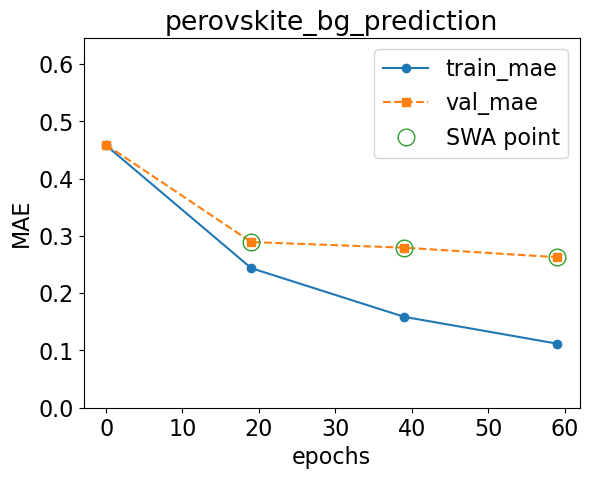

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


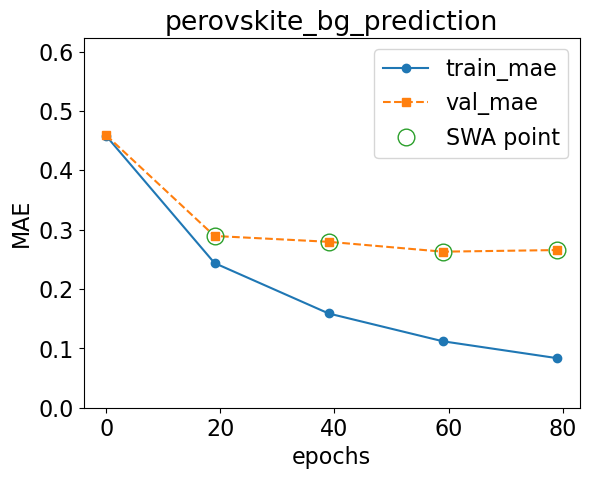

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


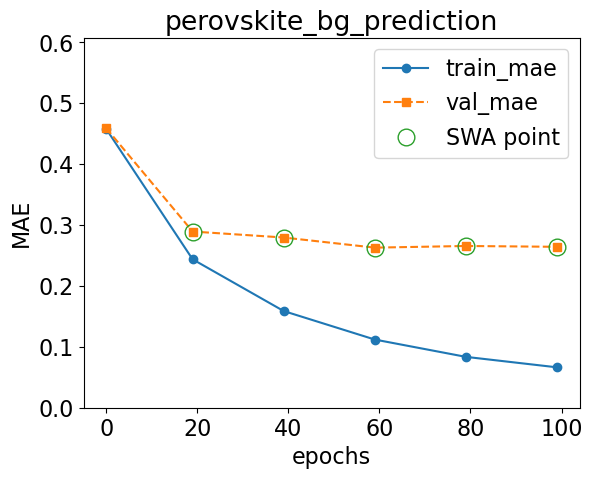

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


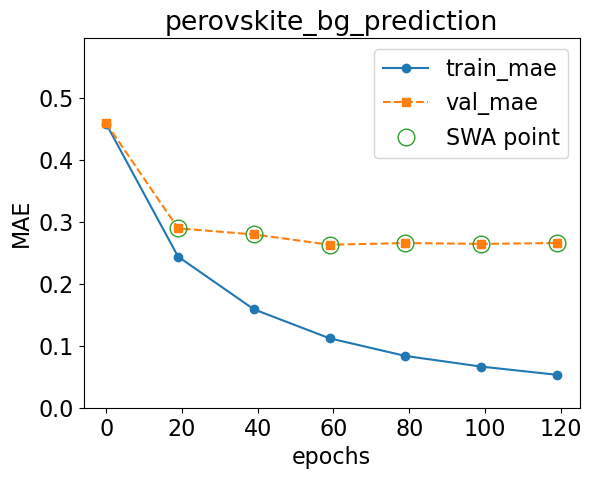

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


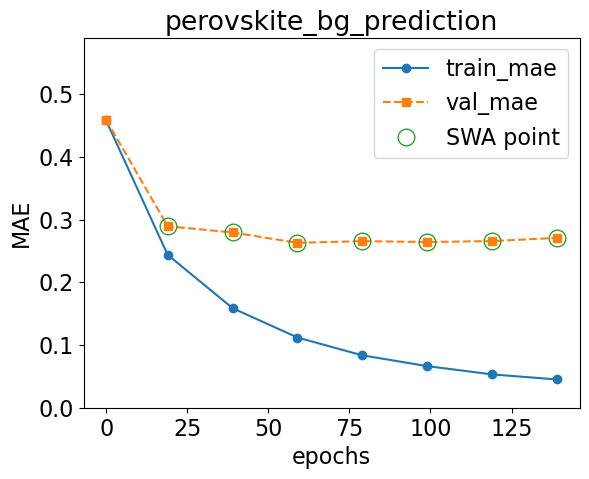

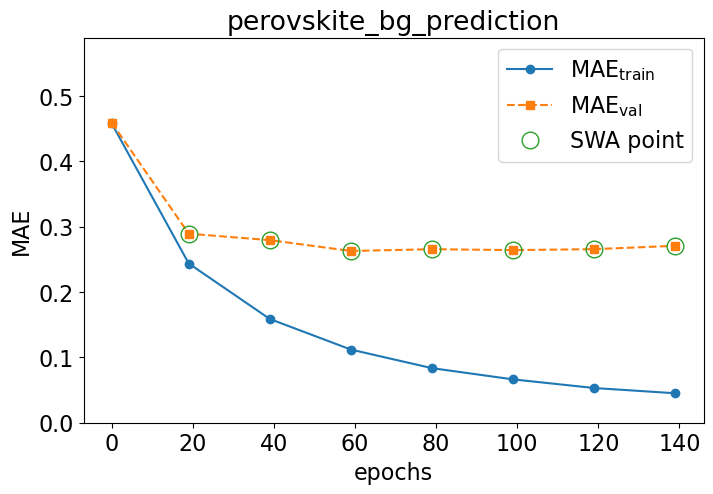

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction) to models/trained_models/perovskite_bg_prediction.pth


In [9]:
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

## Model evaluation

After training, we evaluate the model using the validation data.


Results for source: pvk with data size 1263

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

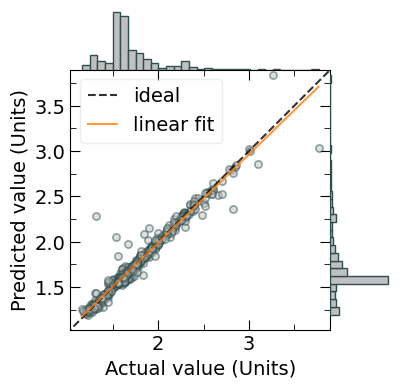

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

R2 score: 0.9663902638497256
MSE: 0.002872835346429683
MAE: 0.020962132511053132 eV

Results for source: chalcogenides with data size 9

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 9/9 [00:00<00:00, 89451.98formulae/s]

loading data with up to 4 elements in the formula


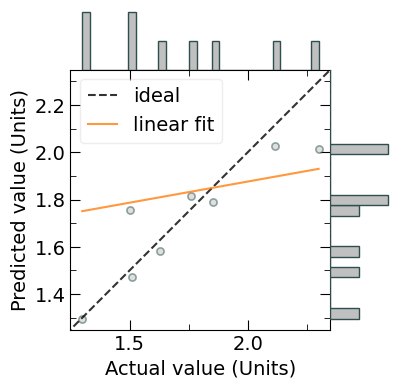

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

R2 score: -1.0586780631093702
MSE: 0.21976388323692522
MAE: 0.24267053869035513 eV

Results for source: chalc_semicon with data size 1630

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1630/1630 [00:00<00:00, 260595.22formulae/s]

loading data with up to 6 elements in the formula


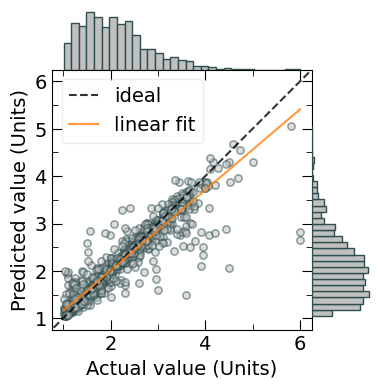

R2 score: 0.880207636878132
MSE: 0.06184184142009554
MAE: 0.1053627983239531 eV


In [10]:
from tf_chpvk_pv.modeling.CrabNet.utils import get_test_r2_score_by_source_data

# Train data
get_test_r2_score_by_source_data(train_df, df, feature_names)

for validation data we have:


Results for source: pvk with data size 158

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 8 elements in the formula


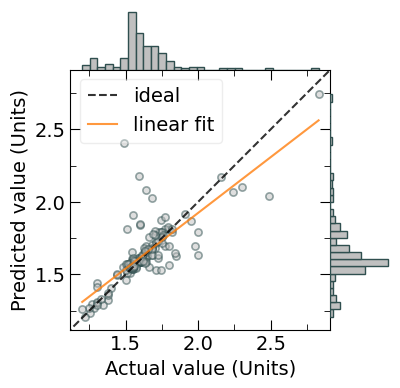

R2 score: 0.5777733581789188
MSE: 0.018079063888912887
MAE: 0.066384031705584 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


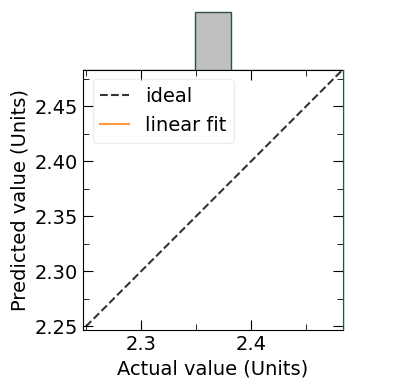

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.09532414805033818
MAE: 0.30874608993530295 eV

Results for source: chalc_semicon with data size 204

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 204/204 [00:00<00:00, 205830.65formulae/s]


loading data with up to 6 elements in the formula


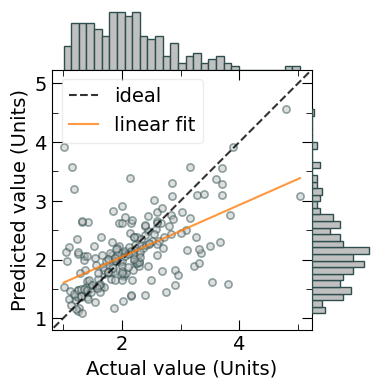

R2 score: 0.23942560987222972
MSE: 0.40257566159757285
MAE: 0.4162115840257383 eV


In [11]:
# Validation data
get_test_r2_score_by_source_data(val_df, df, feature_names)

and finally for test data:


Results for source: pvk with data size 158

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


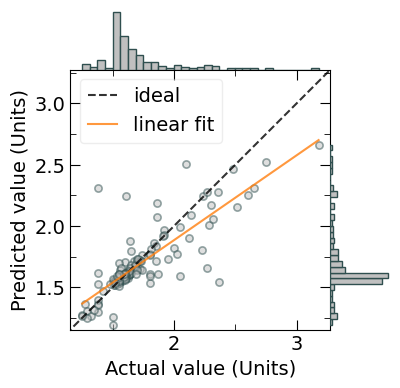

R2 score: 0.6678109466221245
MSE: 0.030435460255912733
MAE: 0.08944124491833291 eV

Results for source: chalcogenides with data size 1

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 3 elements in the formula


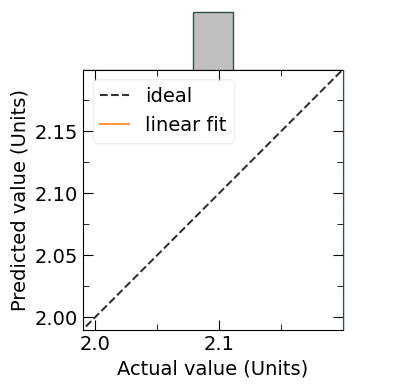

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/sklearn/metrics/_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

R2 score: nan
MSE: 0.1018564574589926
MAE: 0.3191495847702024 eV

Results for source: chalc_semicon with data size 204

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 204/204 [00:00<00:00, 271631.12formulae/s]


loading data with up to 6 elements in the formula


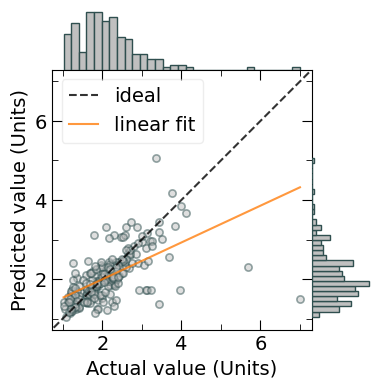

R2 score: 0.2747534725146513
MSE: 0.44523680264966475
MAE: 0.37191381791058703 eV


In [12]:
# Test data
get_test_r2_score_by_source_data(test_df, df, feature_names)

Now the error asociated with the complete test data set...

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 221105.48formulae/s]

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])


loading data with up to 9 elements in the formula


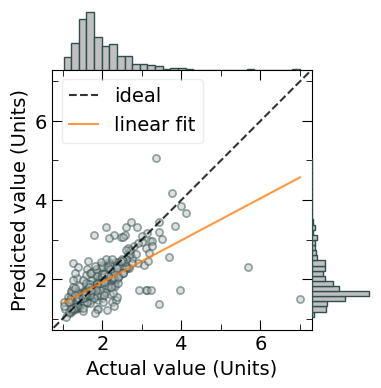

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [13]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
# Test data
test_r2_score(test_df, feature_names)

Let's see the error for all the chalcogenide perovskite compounds.

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 8547.12formulae/s]


loading data with up to 4 elements in the formula


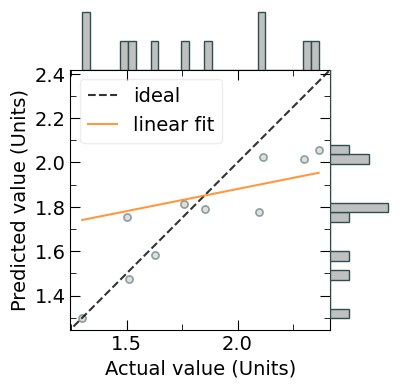

R2 score: -0.48706033246266034
MSE: 0.19773232314924163
MAE: 0.25563004753806373 eV


In [6]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from crabnet.utils.data import groupby_formula  # type: ignore

df_chalcogenides = df[df['source'] == 'chalcogenides'].copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_chalcogenides, how='median')

df_chalc = get_petiffor_features(df_grouped_formula, original_df=df, train=False)

test_r2_score(df_chalc, feature_names)

## Predict Bandgap from New Formulas

Now we are ready to run some predictions using our trainned model. 

In [15]:
#CrystaLLM data predictions
from tf_chpvk_pv.modeling.CrabNet.utils import get_CrystaLLM_predictions, get_SISSO_predictions, get_experimental_predictions

df_CrystaLLM = get_CrystaLLM_predictions()

#SISSO data predictions

df_SISSO = get_SISSO_predictions()

#Experimentally reported data predictions

df_experimental = get_experimental_predictions()


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9258.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1955.39formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9279.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7037.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2683.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 192.43formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9532.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11748.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6472.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5356.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4987.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9137.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9845.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14463.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7653.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6393.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6316.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 166.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4934.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8630.26formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12520.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5592.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6017.65formulae/s]

loading data with up to 3 elements in the formula

Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12157.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3086.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4963.67formulae/s]

loading data with up to 3 elements in the formula



Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5497.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2978.91formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3666.35formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10618.49formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6105.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8756.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6078.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6523.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5915.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9489.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6250.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4297.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12633.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5833.52formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4599.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6533.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4911.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8439.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6335.81formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2432.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14266.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2652.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15947.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5683.34formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7002.18formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5614.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6472.69formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8683.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8830.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4865.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7570.95formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5041.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1345.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10230.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2624.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9000.65formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4629.47formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5405.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10106.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5468.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2460.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11244.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8612.53formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7294.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5433.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3518.71formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9362.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4457.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11683.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3705.22formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2493.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10699.76formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4471.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7898.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6584.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5426.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8208.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12372.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5882.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13617.87formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5722.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4476.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3274.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6967.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9510.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4262.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4249.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8081.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9799.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10782.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3342.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7319.90formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10645.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6887.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8738.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11066.77formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5127.51formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11881.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5005.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5165.40formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4969.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7626.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12557.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4815.50formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11491.24formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4373.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3994.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10810.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5882.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5315.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12228.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14820.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13662.23formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8774.69formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12087.33formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12557.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6141.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13107.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5722.11formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11096.04formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8405.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4471.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11683.30formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1825.99formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7884.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5426.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5857.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9238.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4315.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3883.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12018.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9686.61formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3045.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9446.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6721.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6213.78formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8559.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11781.75formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5343.06formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11586.48formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6492.73formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 300.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1042.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11428.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6563.86formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5295.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4963.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11214.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6978.88formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5398.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10782.27formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4443.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12052.60formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4148.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15252.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3118.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8665.92formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4462.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4963.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7667.83formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 740.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11715.93formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4064.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7025.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4072.14formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4712.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6523.02formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7231.56formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11814.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14463.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6502.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8738.13formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11037.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5216.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6909.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4396.55formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 13443.28formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4410.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11214.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6710.89formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1250.54formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7695.97formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3923.58formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2565.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14463.12formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10356.31formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6482.70formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7049.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8962.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6009.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14413.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2908.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7073.03formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7612.17formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4410.41formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9754.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6626.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5053.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4245.25formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1734.62formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10565.00formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4211.15formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4614.20formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12945.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9362.29formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10922.67formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5629.94formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5295.84formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 1900.45formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9446.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8035.07formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7397.36formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 4337.44formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 3887.21formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12710.01formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5825.42formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10951.19formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 12748.64formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11848.32formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6432.98formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 15534.46formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 6316.72formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 2007.80formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 523.63formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8981.38formulae/s]


loading data with up to 3 elements in the formula


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 14315.03formulae/s]


loading data with up to 3 elements in the formula


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7384.34formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrS3: 1.75 eV
Bandgap prediction for BaZrS3: 1.79 ± 0.16 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 11184.81formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

loading data with up to 3 elements in the formula
Experimental bandgap for BaTiS3: 1.3 eV
Bandgap prediction for BaTiS3: 2.65 ± 3.29 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5405.03formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for LaYS3: 2.3 eV
Bandgap prediction for LaYS3: 2.02 ± 0.14 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9341.43formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for CaZrS3: 1.5 eV
Bandgap prediction for CaZrS3: 1.76 ± 0.15 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9532.51formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaZrSe3: 1.3 eV
Bandgap prediction for BaZrSe3: 1.3 ± 0.07 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 5761.41formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for BaHfS3: 2.17 eV
Bandgap prediction for BaHfS3: 2.03 ± 0.21 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 10058.28formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped t

loading data with up to 3 elements in the formula
Experimental bandgap for SrZrS3: 2.05 eV
Bandgap prediction for SrZrS3: 1.78 ± 0.18 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7724.32formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 3 elements in the formula
Experimental bandgap for SrHfS3: 2.32 eV
Bandgap prediction for SrHfS3: 2.06 ± 0.27 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 8756.38formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for BaZr(S0.6Se0.4)3: 1.76 eV
Bandgap prediction for BaZr(S0.6Se0.4)3: 1.81 ± 0.07 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 7169.75formulae/s]
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.95Ti0.05)S3: 1.63 eV
Bandgap prediction for Ba(Zr0.95Ti0.05)S3: 1.58 ± 0.11 eV

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 1/1 [00:00<00:00, 9118.05formulae/s]

loading data with up to 4 elements in the formula
Experimental bandgap for Ba(Zr0.96Ti0.04)S3: 1.51 eV
Bandgap prediction for Ba(Zr0.96Ti0.04)S3: 1.47 ± 0.05 eV


# Training without Chalcogenide perovskites

The shape of the DataFrame is:  (3617, 3)
After cleaning and groupin the data, the sources percentages are:
43.65 % from halide perovskites,
56.35 % from chalcogenide semiconductors

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2893/2893 [00:00<00:00, 128372.16formulae/s]


skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 344.0), ('I', 150.0), ('B', 50.0), ('Pb', 50.0), ('C', 49.0), ('N', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 38.0), ('I', 15.0), ('C', 9.0), ('N', 5.0),

Generating EDM: 100%|██████████| 362/362 [00:00<00:00, 140651.97formulae/s]


skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 230 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.45 val mae: 0.421


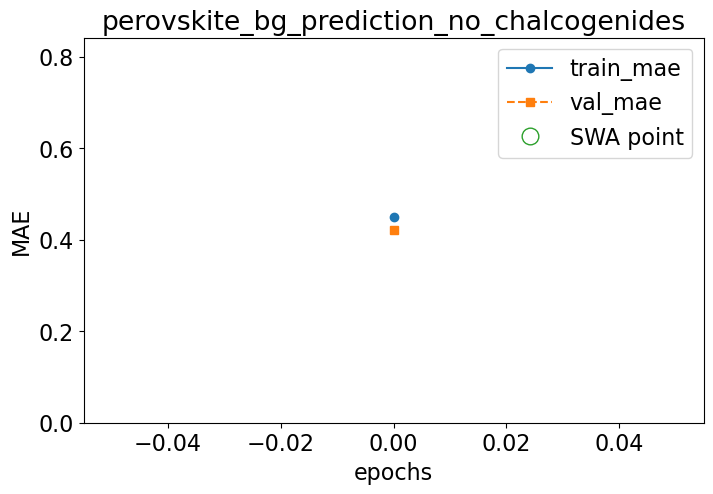

Epoch: 19/300 --- train mae: 0.183 val mae: 0.281


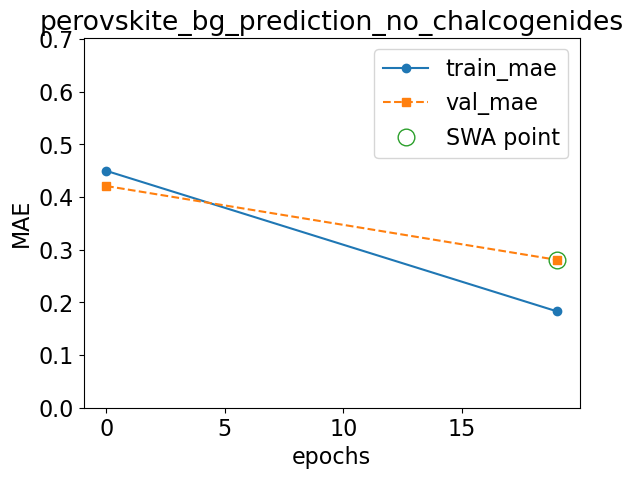

Epoch: 39/300 --- train mae: 0.113 val mae: 0.259


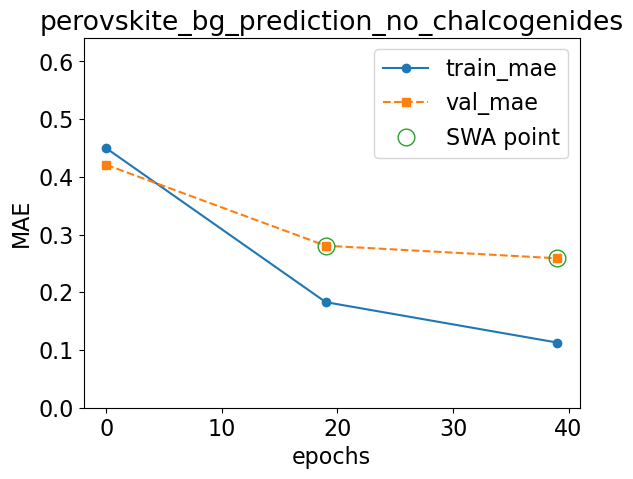

Epoch: 59/300 --- train mae: 0.0767 val mae: 0.256


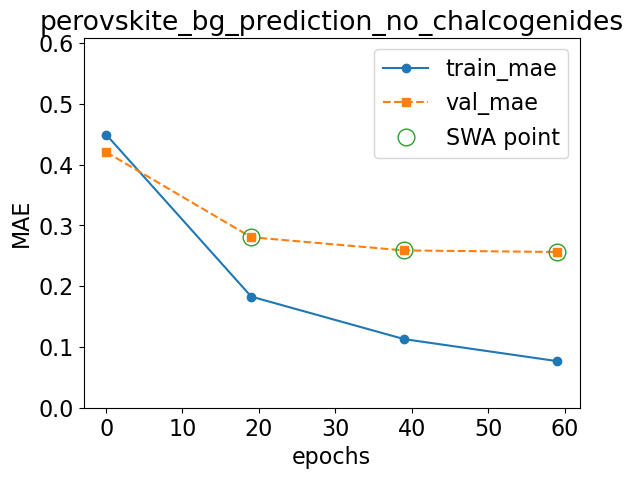

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0553 val mae: 0.261


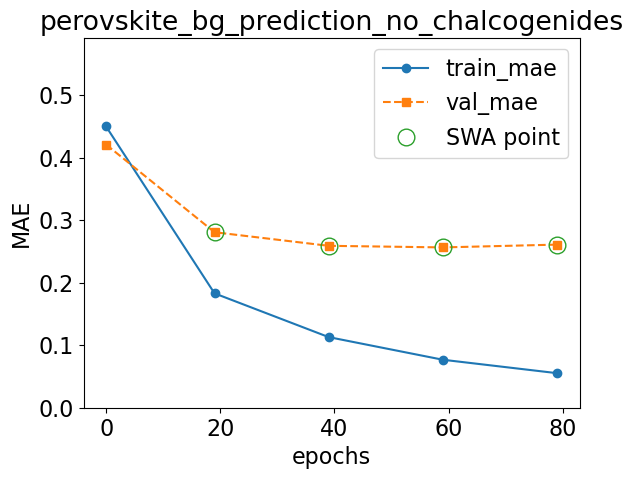

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 0.0426 val mae: 0.266


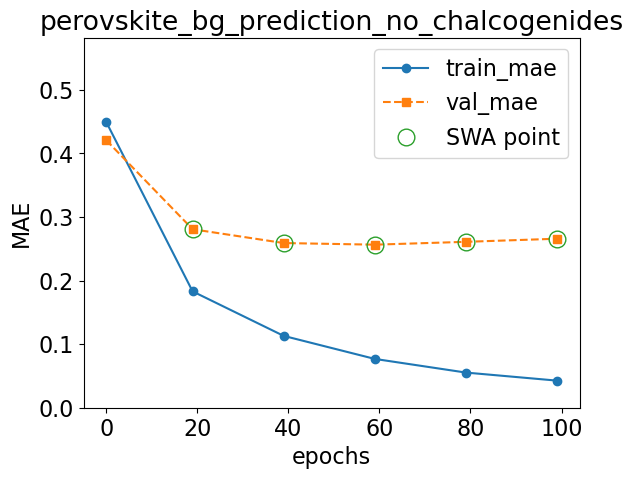

Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 0.037 val mae: 0.268


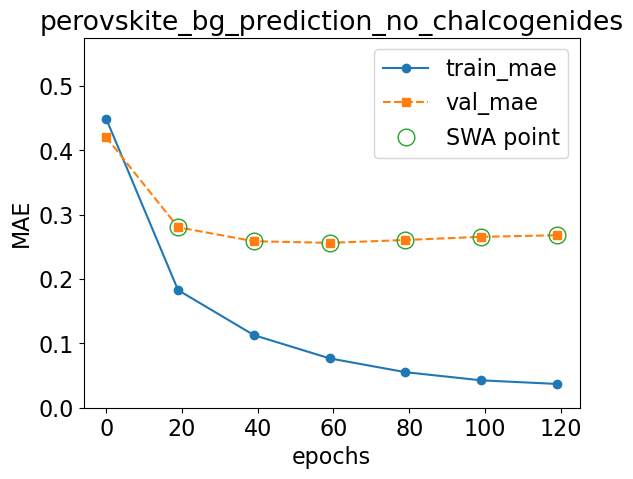

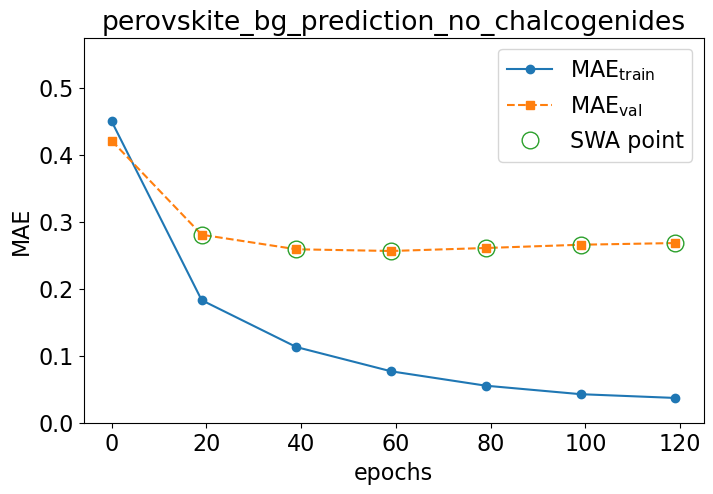

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_prediction_no_chalcogenides) to models/trained_models/perovskite_bg_prediction_no_chalcogenides.pth


In [ ]:
df_no_chalcogenides = df[df['source'] != 'chalcogenides'].copy()

from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_no_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_no_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_no_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

for formula in df_grouped_formula['formula']:
    df_grouped_formula.loc[df_grouped_formula['formula'] == formula, 'source'] = df_no_chalcogenides.loc[df_no_chalcogenides['formula'] == formula, 'source'].values[0]

sc_percent = (df_grouped_formula.source.value_counts() / df_grouped_formula.shape[0] * 100).to_dict()
sources = [sc_percent.get(sc) for sc in ['pvk', 'chalc_semicon']]

txt = 'After cleaning and groupin the data, the sources percentages are:' \
      '\n{0:.2f} % from halide perovskites,' \
      '\n{1:.2f} % from chalcogenide semiconductors'.format(*sources)
print(txt)
df_grouped_formula.drop(columns=['source'], inplace=True)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df)

from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_prediction_no_chalcogenides', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they are <b>NOT</b> included in the training dataset

The shape of the DataFrame is:  (11, 3)


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 11133.53formulae/s]


loading data with up to 4 elements in the formula


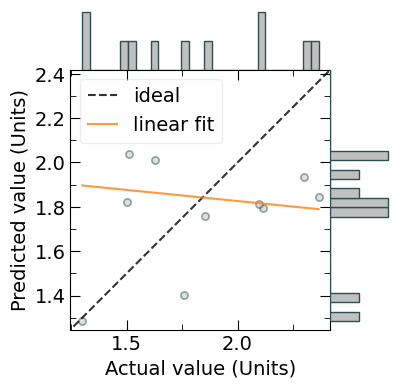

R2 score: -1.0246045133090256
MSE: 0.2692088176490213
MAE: 0.4086695562709462 eV


In [6]:
df_chalcogenides = df[df['source'] == 'chalcogenides'].copy()

# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_chalcogenides.rename(columns={'bandgap': 'target'}, inplace=True)
df_chalcogenides.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_chalcogenides, how='median')

print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

df_test_chalcogenides = get_petiffor_features(df_grouped_formula, original_df=df, train=False)

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS


# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction_no_chalcogenides.pth')

Comparision of predicted and actual values for the chalcogenide perovskite data set, when they <b>are</b> included in the training dataset

/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


Generating EDM: 100%|██████████| 11/11 [00:00<00:00, 58624.33formulae/s]


loading data with up to 4 elements in the formula


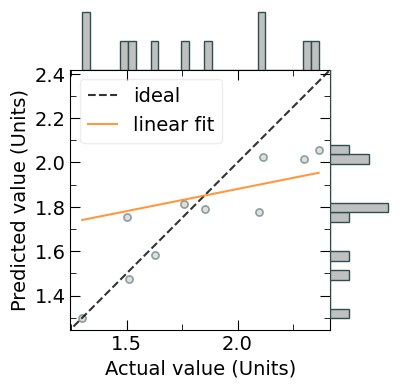

R2 score: -0.48706033246266034
MSE: 0.19773232314924163
MAE: 0.25563004753806373 eV


In [7]:
# Perovskite chalcogenide test data
test_r2_score(df_test_chalcogenides, feature_names,
              model_path = TRAINED_MODELS / 'perovskite_bg_prediction.pth')

In [8]:
def mean_absolute_error(y_true, y_pred):
    if len(y_true) != len(y_pred):
        raise ValueError("Input lists must have the same length.")
    errors = [abs(t - p) for t, p in zip(y_true, y_pred)]
    return sum(errors) / len(errors)

MAE_null_ch = mean_absolute_error(df_test_chalcogenides['target'], df_test_chalcogenides['target'].median().repeat(df_test_chalcogenides.shape[0]))
MAE_null_df = mean_absolute_error(test_df['target'], test_df['target'].median().repeat(test_df.shape[0]))

print('Mean Absolute Error (MAE) null model (median) for test chalcogenide perovskites: {:.4f} eV'.format(MAE_null_ch))
print('Mean Absolute Error (MAE) null model (median) for the test dataset: {:.4f} eV'.format(MAE_null_df))

MAE_null_ch = mean_absolute_error(df_chalcogenides['target'], df_chalcogenides['target'].median().repeat(df_chalcogenides.shape[0]))
MAE_null_df = mean_absolute_error(test_df['target'], test_df['target'].median().repeat(test_df.shape[0]))

print('Mean Absolute Error (MAE) null model (median) for whole dataset of chalcogenide perovskites: {:.4f} eV'.format(MAE_null_ch))

MAE_null_ch = mean_absolute_error(df_test_chalcogenides['target'], df_test_chalcogenides['target'].mean().repeat(df_test_chalcogenides.shape[0]))
MAE_null_df = mean_absolute_error(test_df['target'], test_df['target'].mean().repeat(test_df.shape[0]))

print('Mean Absolute Error (MAE) null model (mean) for test chalcogenide perovskites: {:.4f} eV'.format(MAE_null_ch))
print('Mean Absolute Error (MAE) null model (mean) for the test dataset: {:.4f} eV'.format(MAE_null_df))

Mean Absolute Error (MAE) null model (median) for test chalcogenide perovskites: 0.3173 eV
Mean Absolute Error (MAE) null model (median) for the test dataset: 0.4755 eV
Mean Absolute Error (MAE) null model (median) for whole dataset of chalcogenide perovskites: 0.2835 eV
Mean Absolute Error (MAE) null model (mean) for test chalcogenide perovskites: 0.3203 eV
Mean Absolute Error (MAE) null model (mean) for the test dataset: 0.5091 eV


# Training only Halide perovskites

The shape of the DataFrame is:  (1579, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 1263/1263 [00:00<00:00, 117524.26formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 95.0), ('N', 38.0), ('C', 19.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 10.0), ('C', 6.0), ('N', 3.0), ('Pb', 3.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 38.0), ('I', 15.0), ('C', 9.0), ('N', 5.0), ('Pb', 5.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 6.0), ('I', 3.0), ('P', 2.0)

Generating EDM: 100%|██████████| 158/158 [00:00<00:00, 108337.43formulae/s]


skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 100 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.195 val mae: 0.172


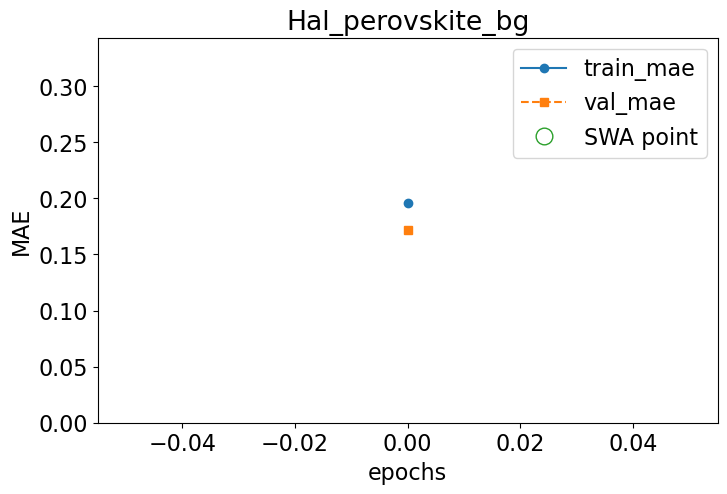

Epoch: 19/300 --- train mae: 0.0764 val mae: 0.0921


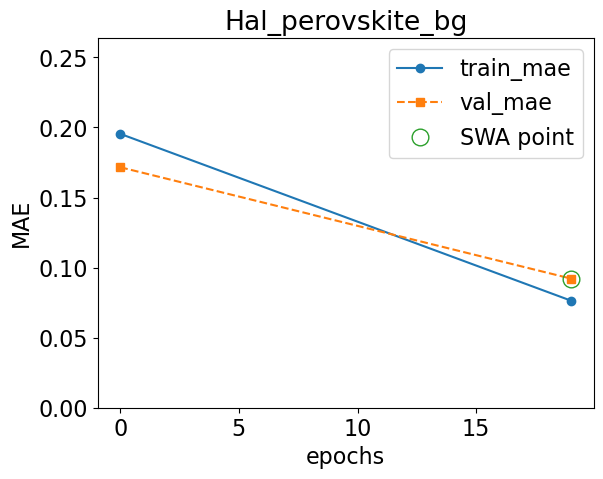

Epoch: 39/300 --- train mae: 0.0453 val mae: 0.0852


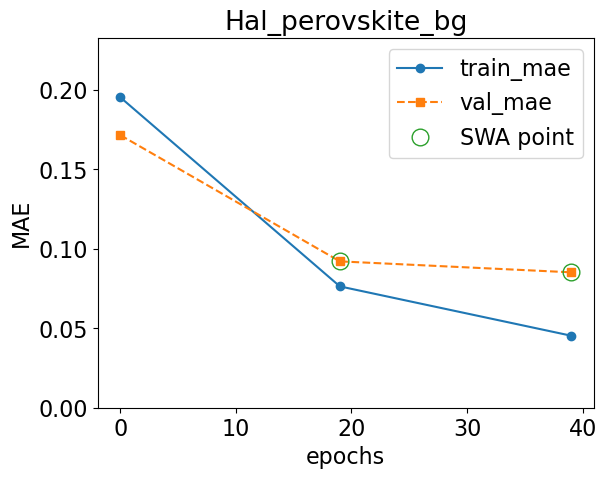

Epoch: 59/300 --- train mae: 0.0321 val mae: 0.0842


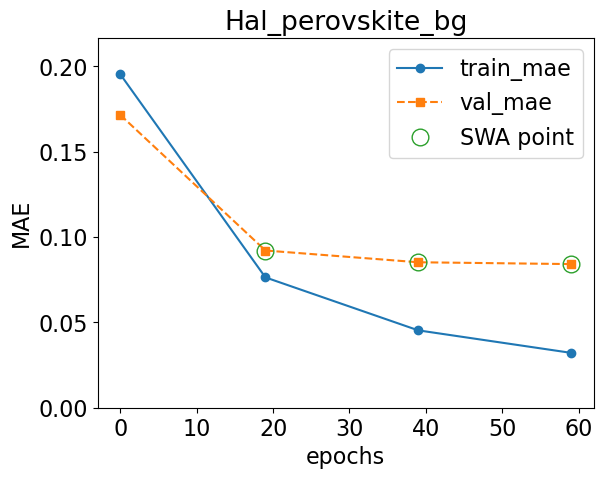

Epoch: 79/300 --- train mae: 0.0247 val mae: 0.0822


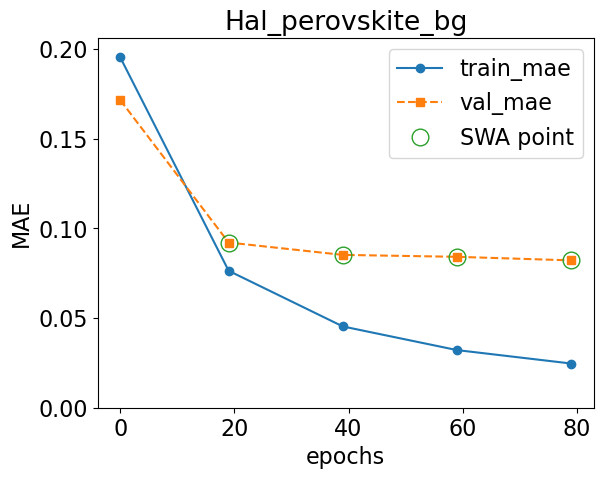

Epoch: 99/300 --- train mae: 0.0197 val mae: 0.0793


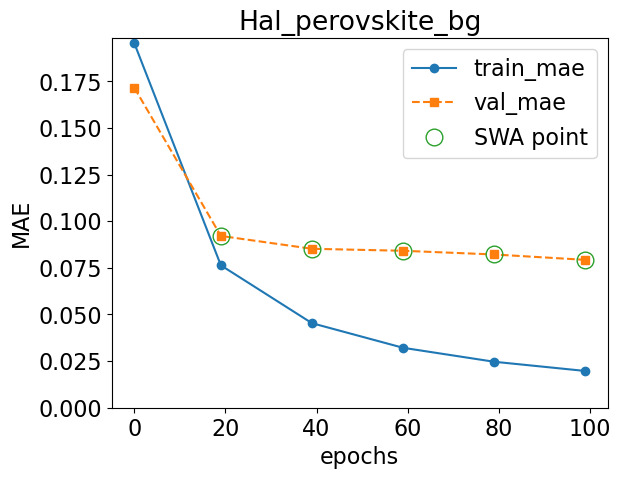

Epoch 119 failed to improve.
Discarded: 1/3 weight updates
Epoch: 119/300 --- train mae: 0.0161 val mae: 0.0823


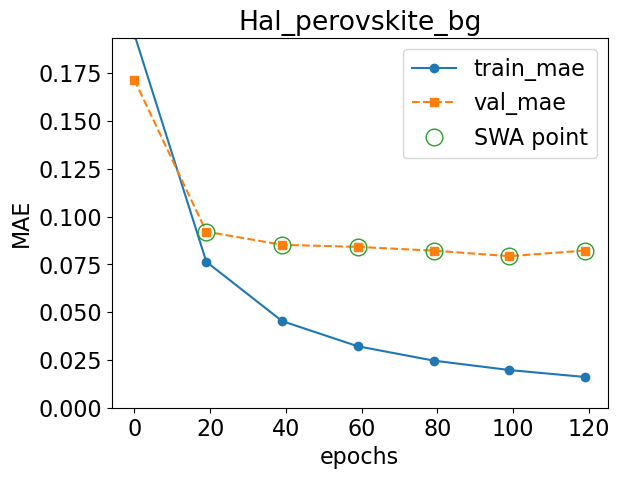

Epoch 139 failed to improve.
Discarded: 2/3 weight updates
Epoch: 139/300 --- train mae: 0.0144 val mae: 0.081


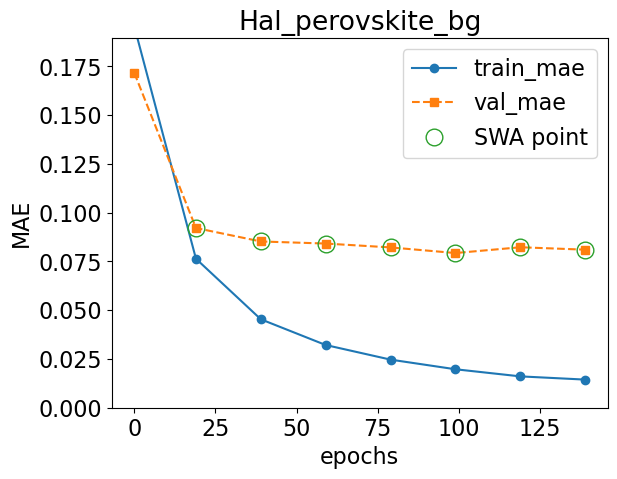

Epoch 159 failed to improve.
Discarded: 3/3 weight updates
Epoch: 159/300 --- train mae: 0.0132 val mae: 0.0795


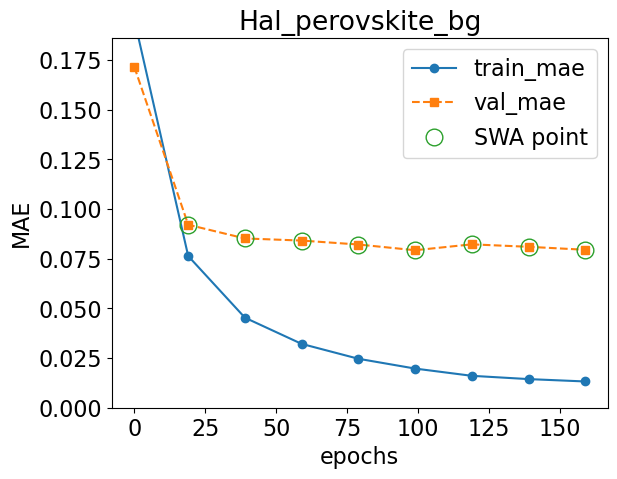

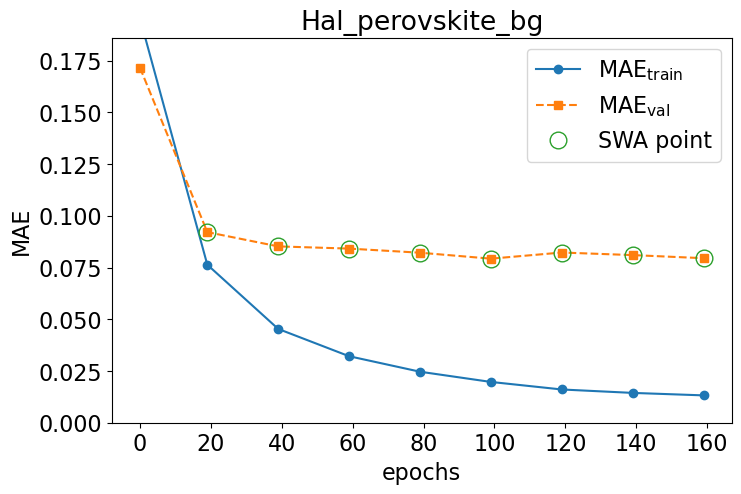

Discarded: 3/3weight updates, early-stopping now
Saving network (Hal_perovskite_bg) to models/trained_models/Hal_perovskite_bg.pth

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 344.0), ('I', 150.0), ('B', 50.0), ('Pb', 50.0), ('C', 49.0), ('N', 49.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 8 elements in the formula


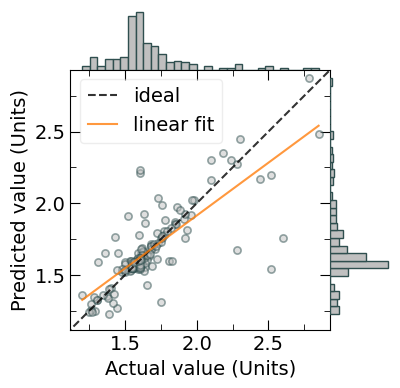

R2 score: 0.603527232098111
MSE: 0.029693445708950425
MAE: 0.08658501443268464 eV


In [3]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS

df_Hpvk = df[df['source'] == 'pvk'].copy()

from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_Hpvk.rename(columns={'bandgap': 'target'}, inplace=True)
df_Hpvk.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_Hpvk, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_Hpvk)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='Hal_perovskite_bg', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, feature_names,
              model_path = TRAINED_MODELS / 'Hal_perovskite_bg.pth')

# Training only chalcogenide semiconductors

The shape of the DataFrame is:  (2039, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 1631/1631 [00:00<00:00, 165904.59formulae/s]


loading data with up to 6 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 204/204 [00:00<00:00, 135686.33formulae/s]


loading data with up to 6 elements in the formula
stepping every 130 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.555 val mae: 0.556


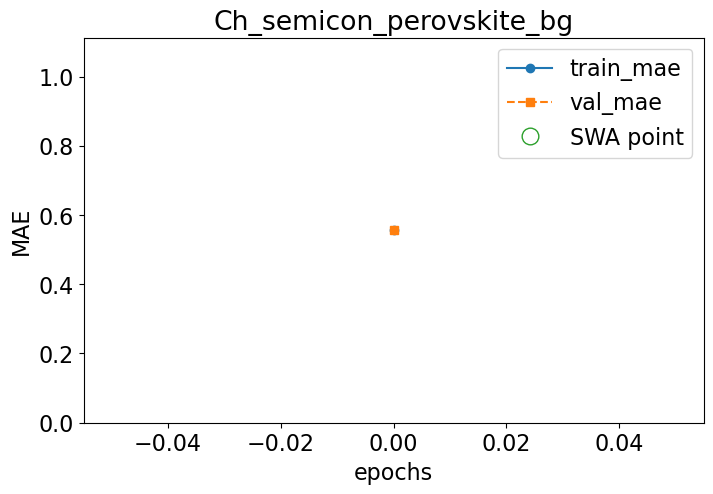

Epoch: 19/300 --- train mae: 0.295 val mae: 0.395


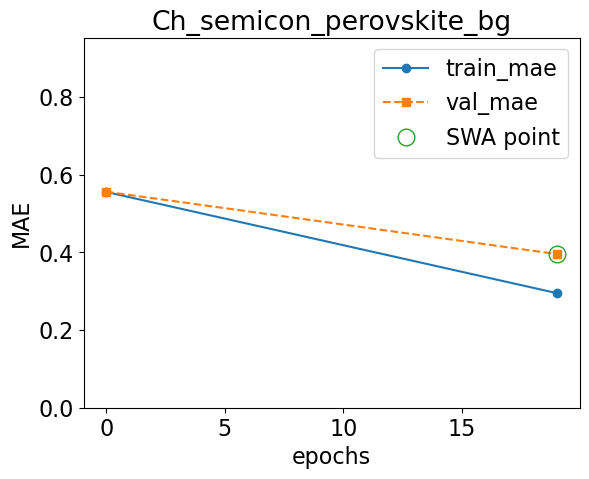

Epoch: 39/300 --- train mae: 0.182 val mae: 0.385


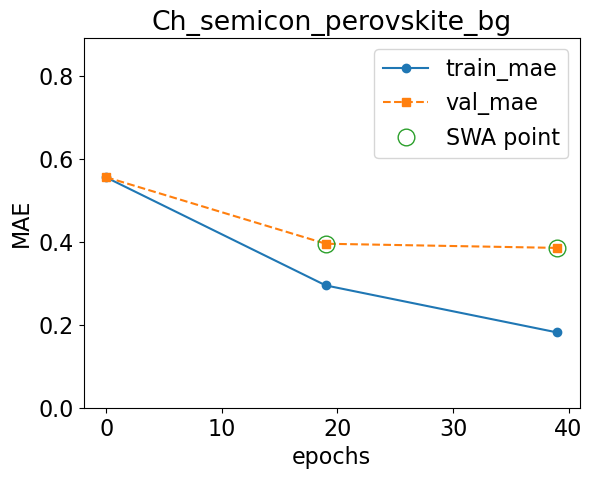

Epoch: 59/300 --- train mae: 0.111 val mae: 0.383


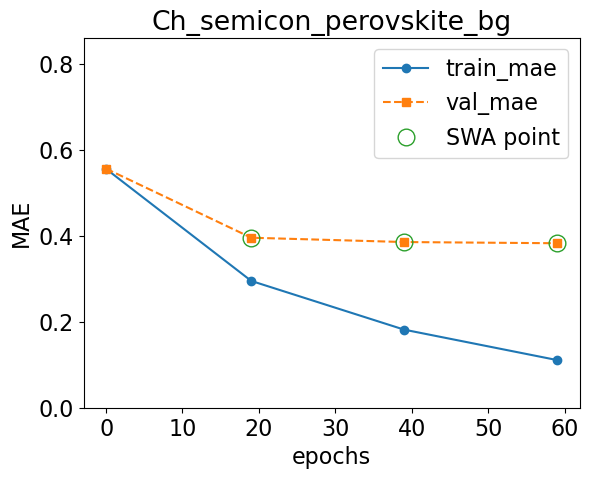

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0739 val mae: 0.39


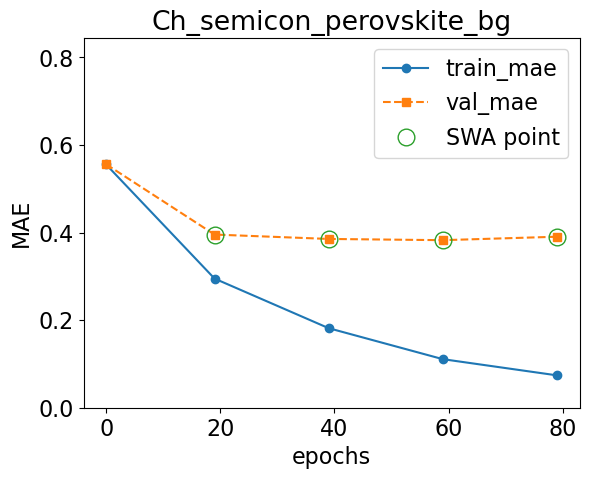

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 0.0591 val mae: 0.39


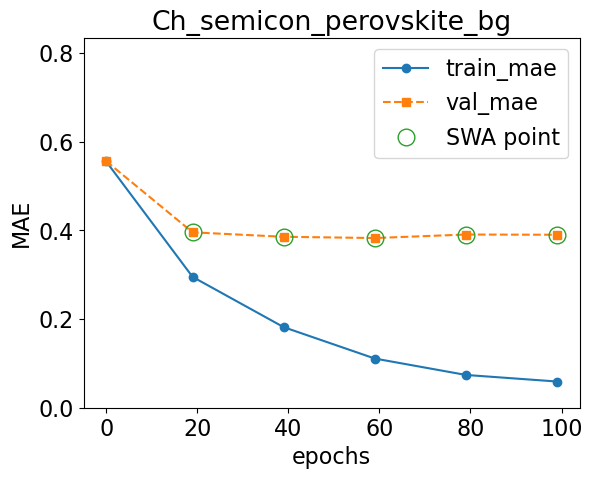

Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 0.0471 val mae: 0.394


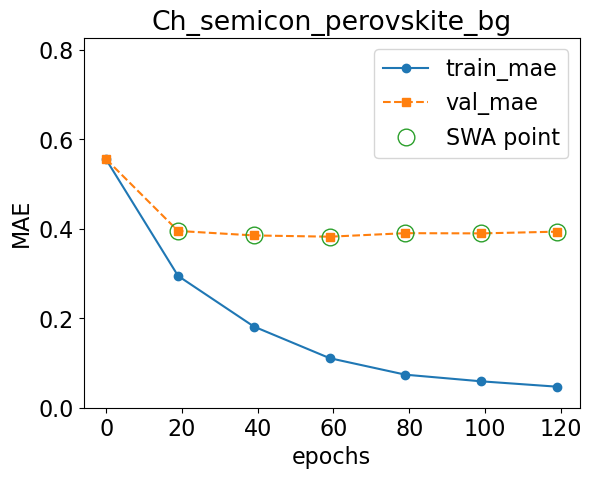

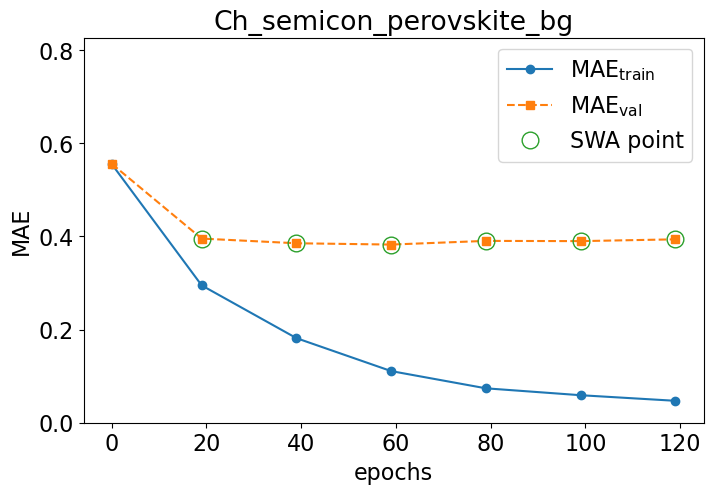

Discarded: 3/3weight updates, early-stopping now
Saving network (Ch_semicon_perovskite_bg) to models/trained_models/Ch_semicon_perovskite_bg.pth

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

loading data with up to 6 elements in the formula


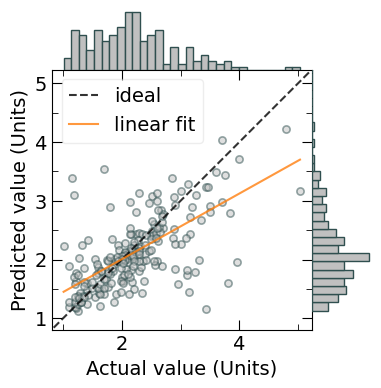

R2 score: 0.31331649968929054
MSE: 0.36323883726451994
MAE: 0.3893037940941605 eV


In [3]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS

df_Ch_sem = df[df['source'] == 'chalc_semicon'].copy()

from crabnet.utils.data import groupby_formula  # type: ignore
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_Ch_sem.rename(columns={'bandgap': 'target'}, inplace=True)
df_Ch_sem.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_Ch_sem, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_Ch_sem)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='Ch_semicon_perovskite_bg', elem_prop='mat2vec', learningcurve=True,
                          extend_features=feature_names)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, feature_names,
              model_path = TRAINED_MODELS / 'Ch_semicon_perovskite_bg.pth')

# Train with different encoders

2026-02-08 22:04:15.354 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 89910.92formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 196862.21formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


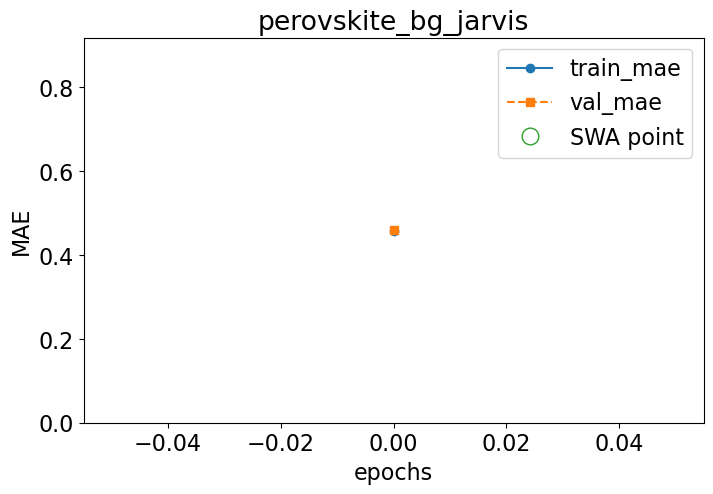

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


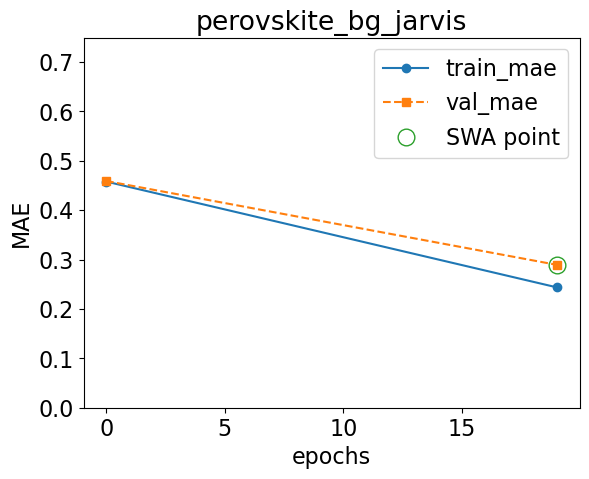

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


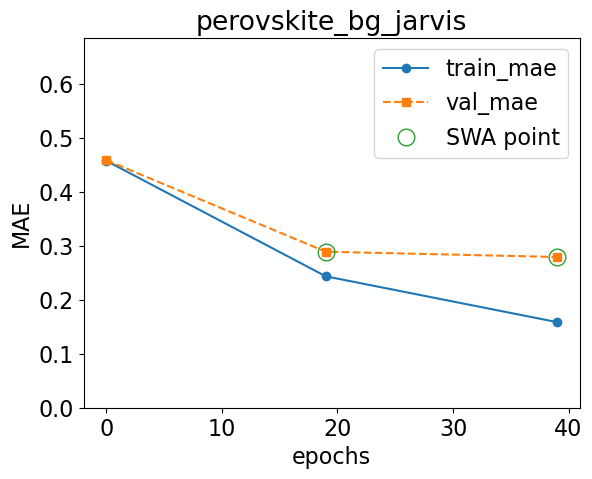

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


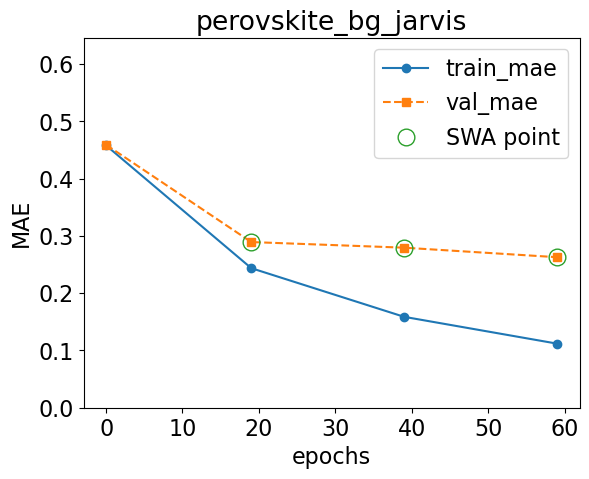

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


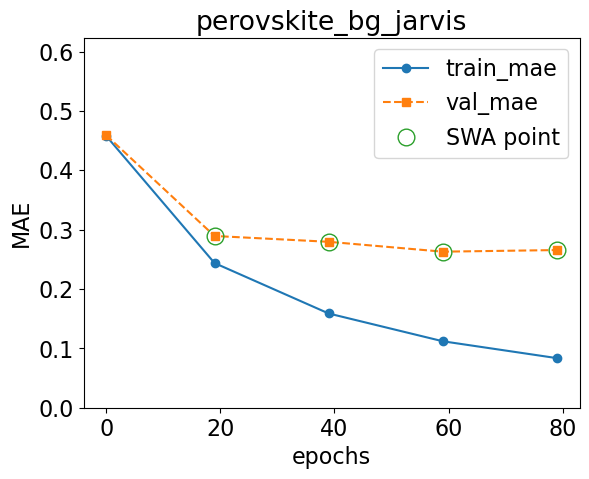

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


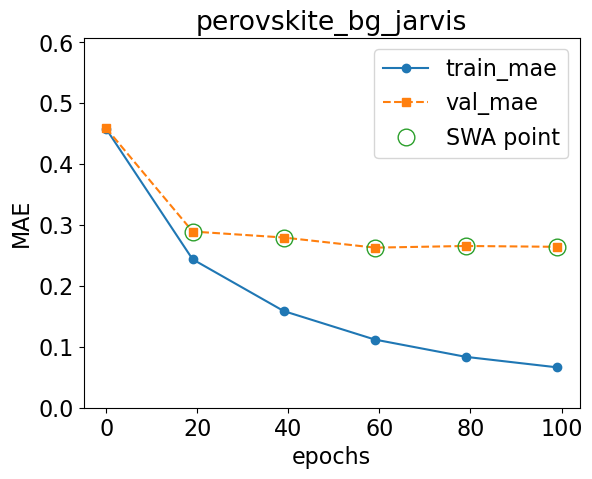

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


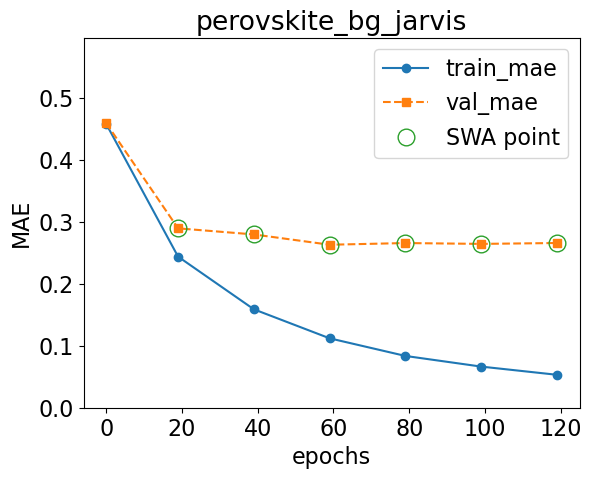

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


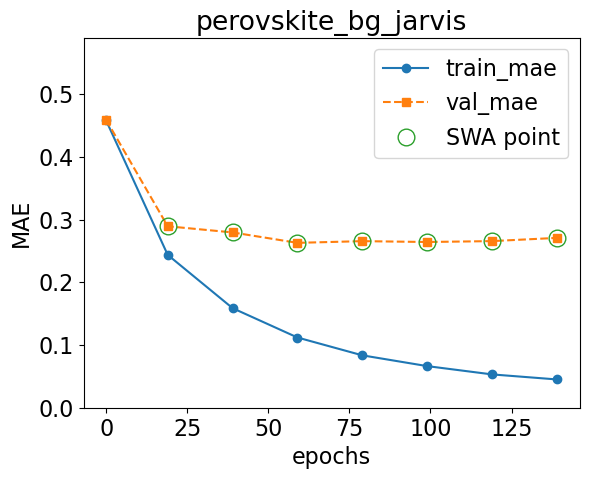

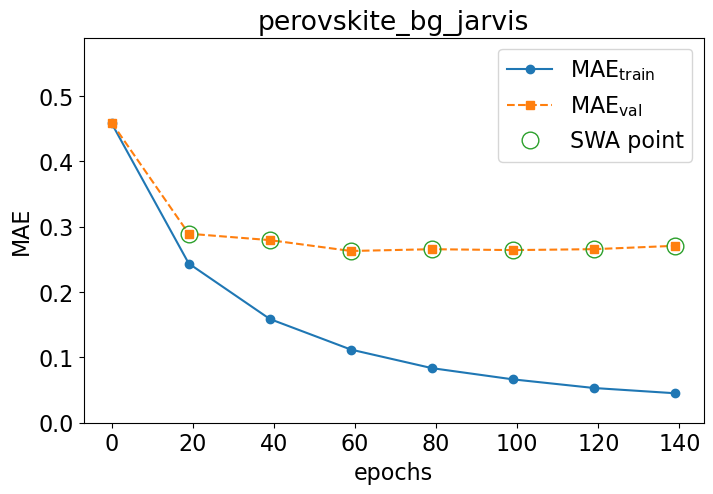

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_jarvis) to models/trained_models/perovskite_bg_jarvis.pth

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic

No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 229331.58formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


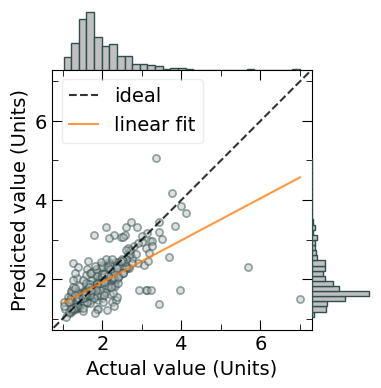

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[0]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_jarvis', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_jarvis.pth')

2026-02-08 22:08:18.946 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 161816.94formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 210731.12formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


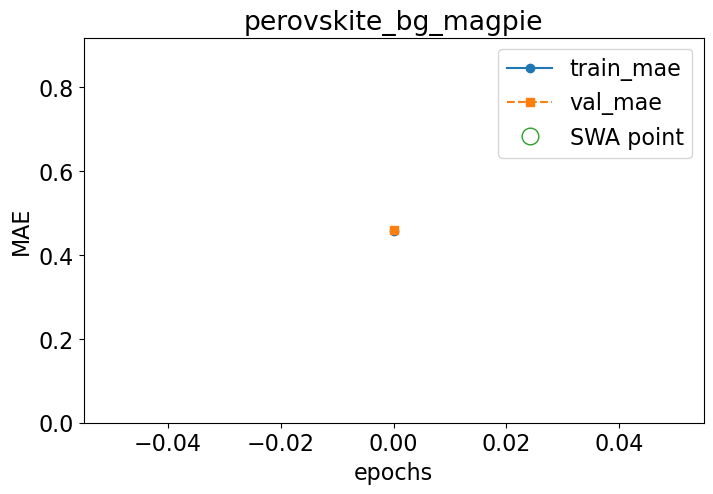

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


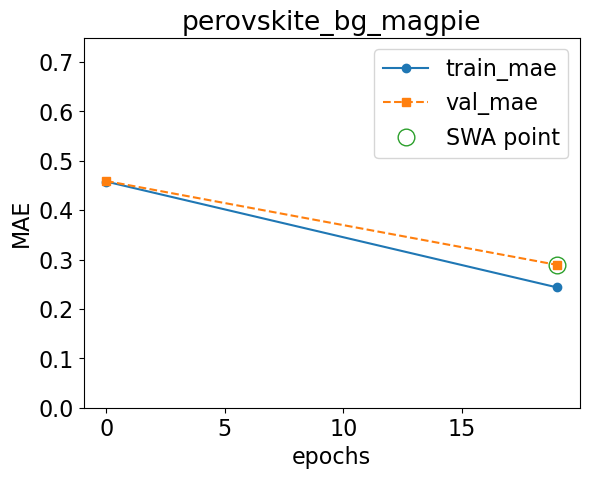

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


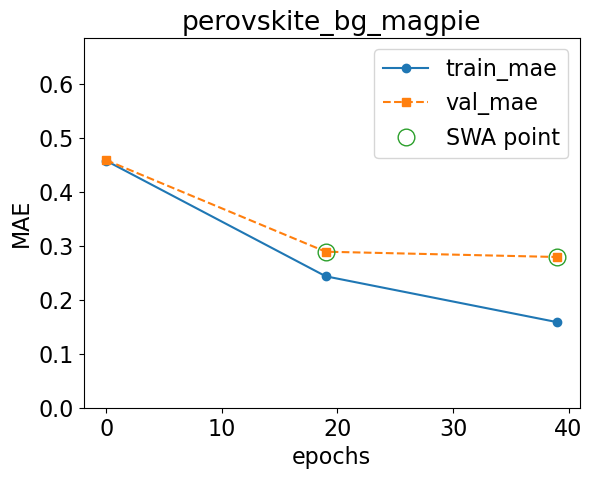

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


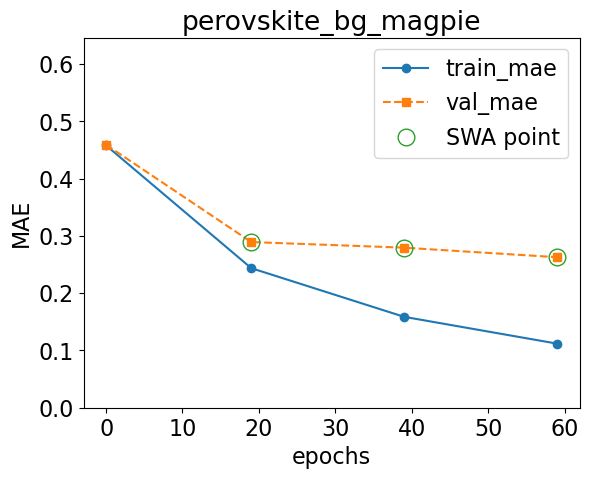

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


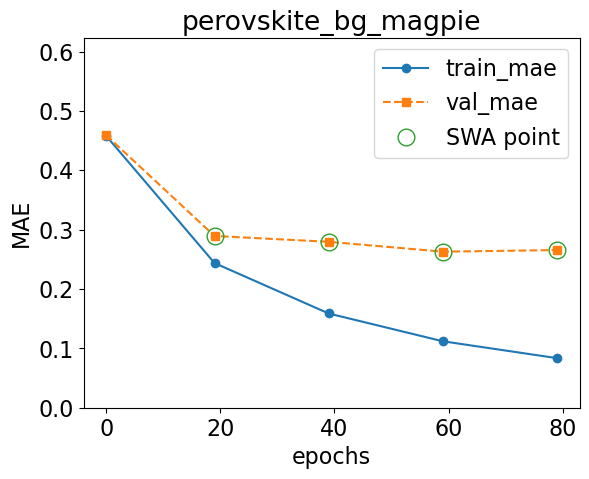

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


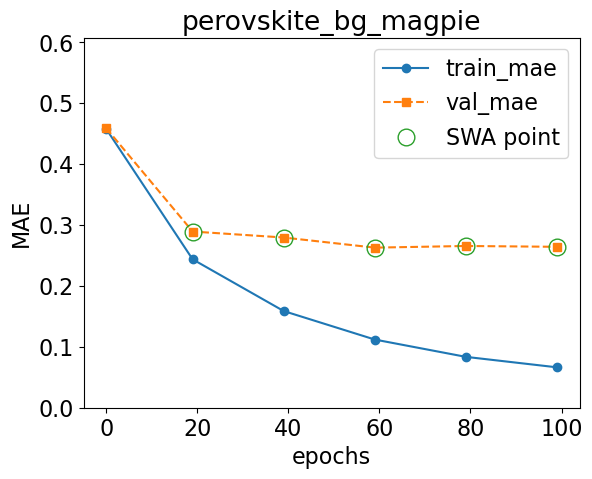

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


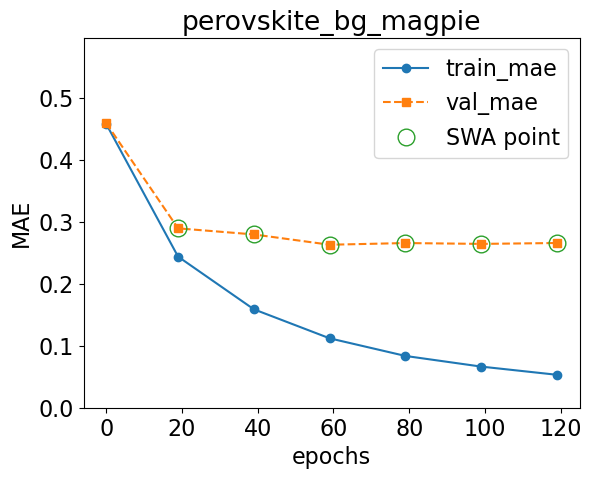

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


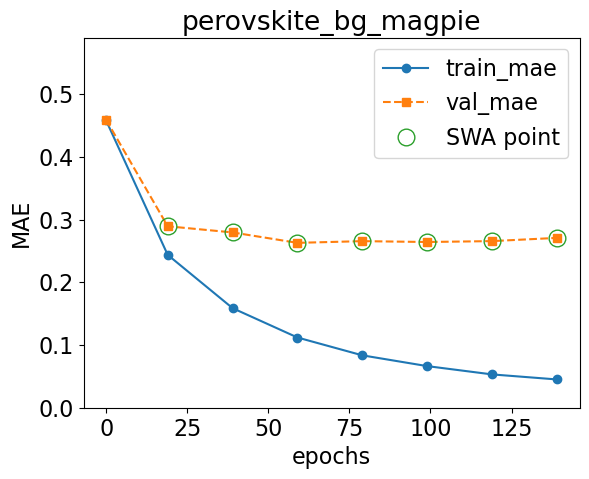

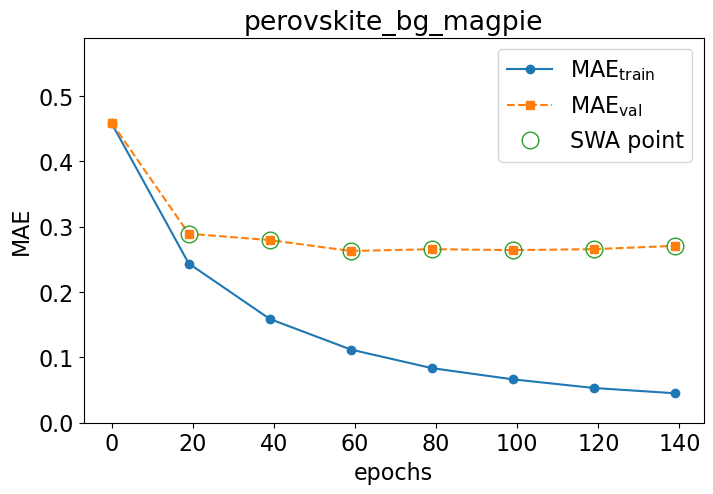

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_magpie) to models/trained_models/perovskite_bg_magpie.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 154227.35formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


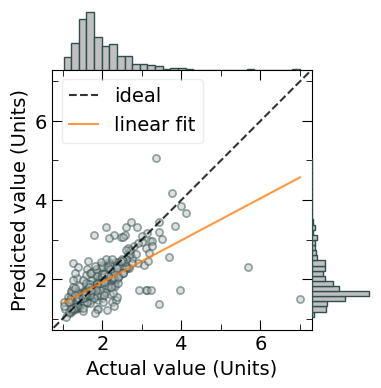

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[1]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_magpie', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_magpie.pth')

2026-02-08 22:11:53.167 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM:   0%|          | 0/2902 [00:00<?, ?formulae/s]

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 26823.11formulae/s]


skipping composition OrderedDict([('H', 95.0), ('N', 38.0), ('C', 19.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 6.0), ('I', 3.0), ('P', 2.0), ('C', 1.0), ('N', 1.0), ('Pb', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 61479.20formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


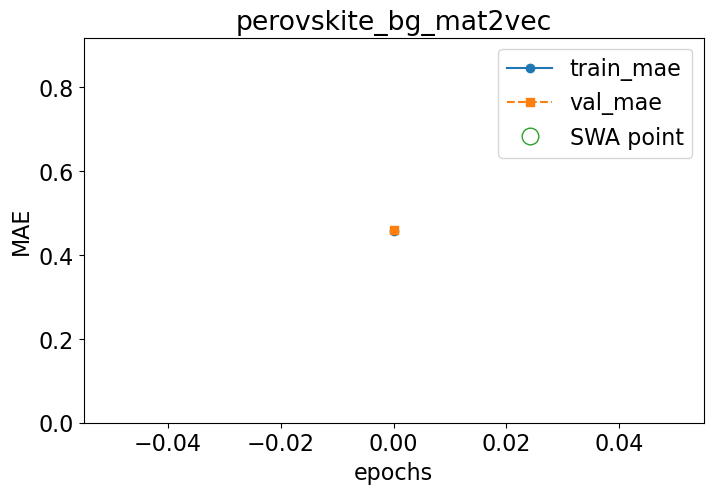

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


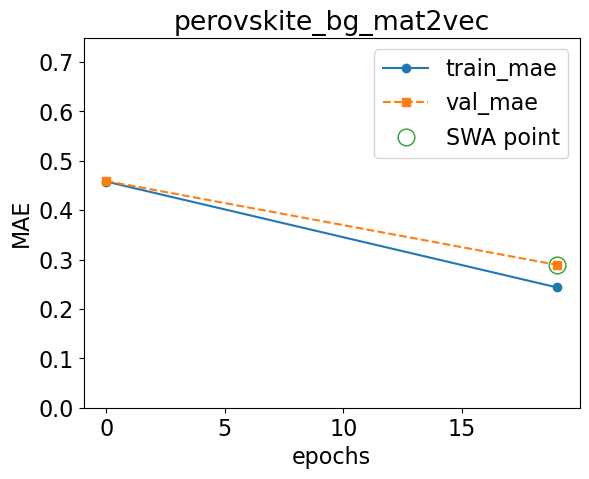

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


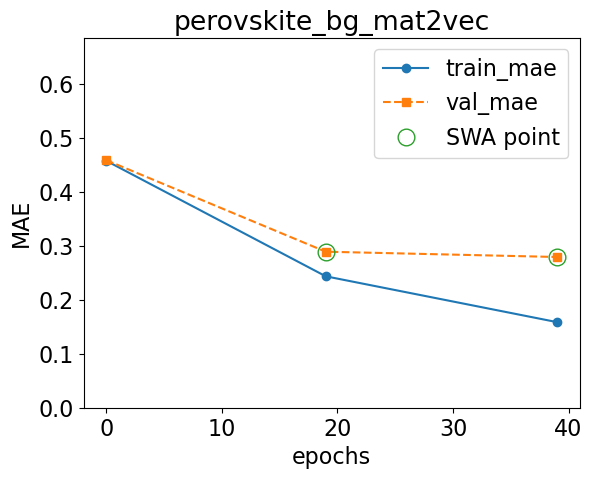

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


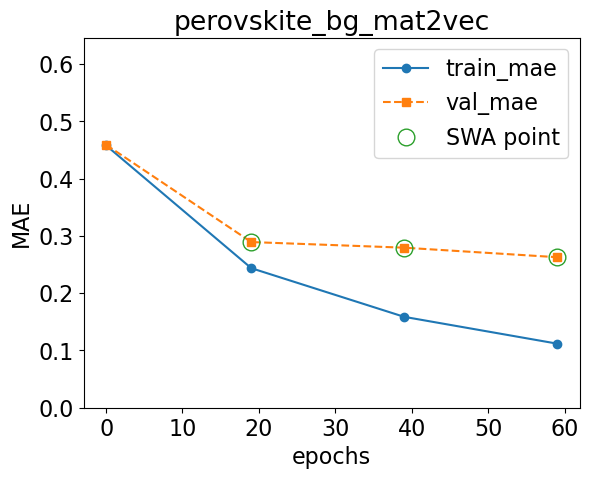

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


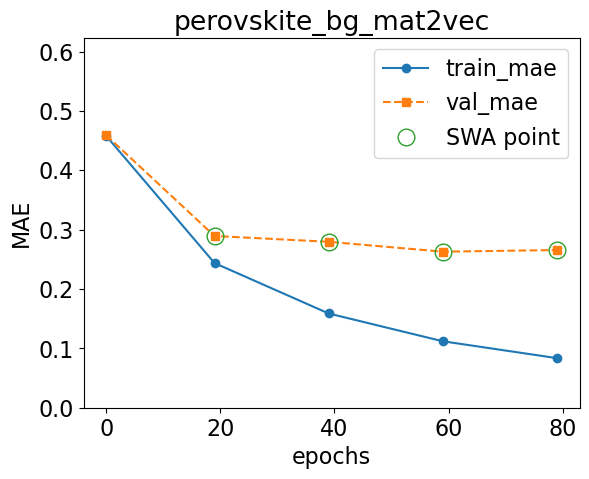

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


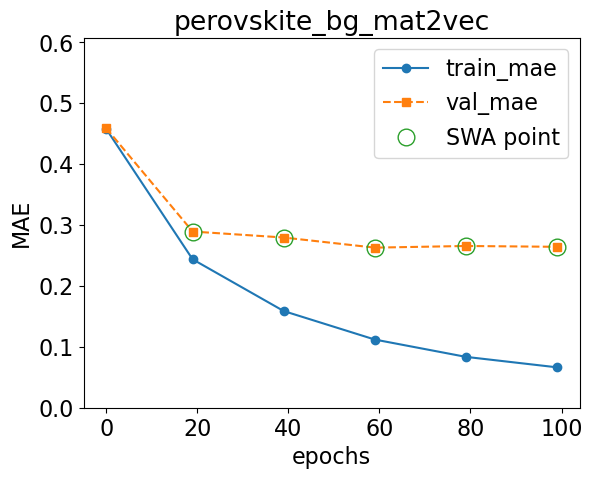

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


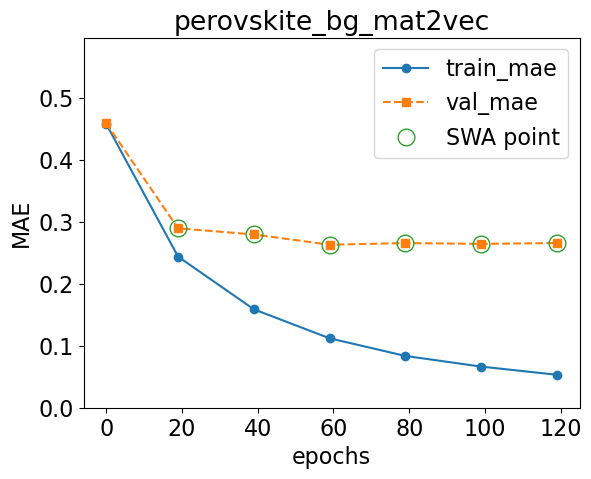

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


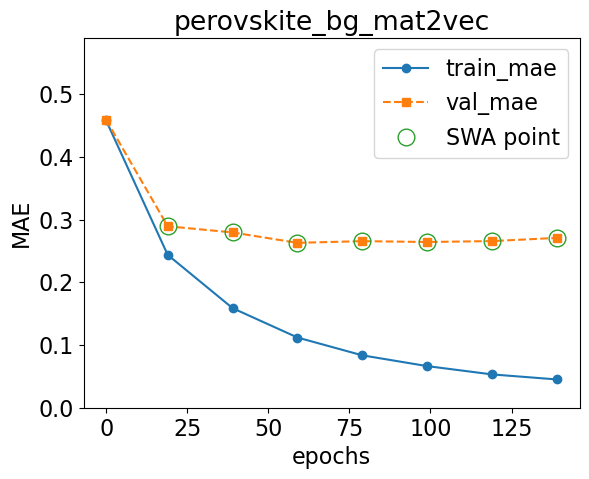

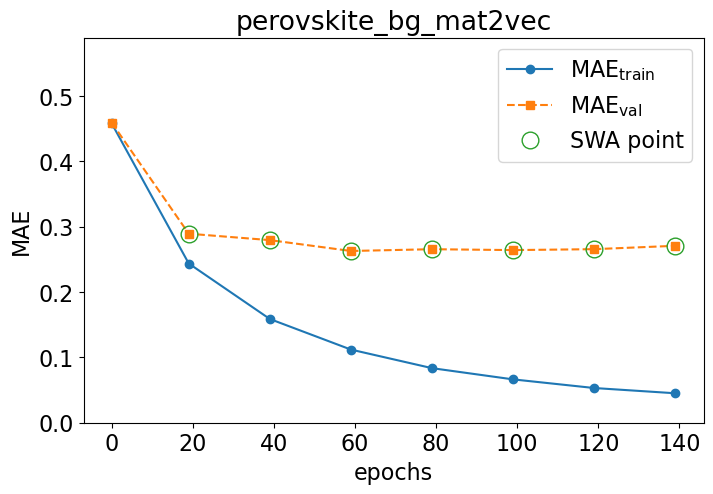

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_mat2vec) to models/trained_models/perovskite_bg_mat2vec.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 129831.36formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


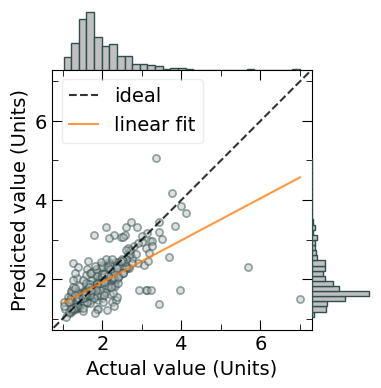

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[2]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_mat2vec', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_mat2vec.pth')

2026-02-08 22:16:31.852 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM:   0%|          | 0/2902 [00:00<?, ?formulae/s]

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 22967.05formulae/s]


skipping composition OrderedDict([('H', 38.0), ('I', 15.0), ('C', 9.0), ('N', 5.0), ('Pb', 5.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 344.0), ('I', 150.0), ('B', 50.0), ('Pb', 50.0), ('C', 49.0), ('N', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 3.0), ('Pb', 1.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 10.0), ('C', 6.0), ('N', 3.0), ('Pb', 3.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 95.0), ('N', 38.0), ('C', 19.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 6.0), ('I', 3.0), ('P', 2.0), ('C', 1.0), ('N', 1.0), ('Pb', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
training with batchsize 256 (2**8.000)


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 128581.40formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


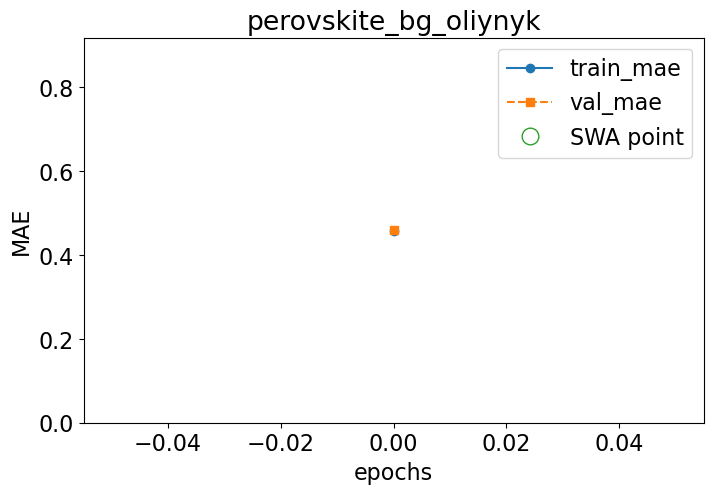

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


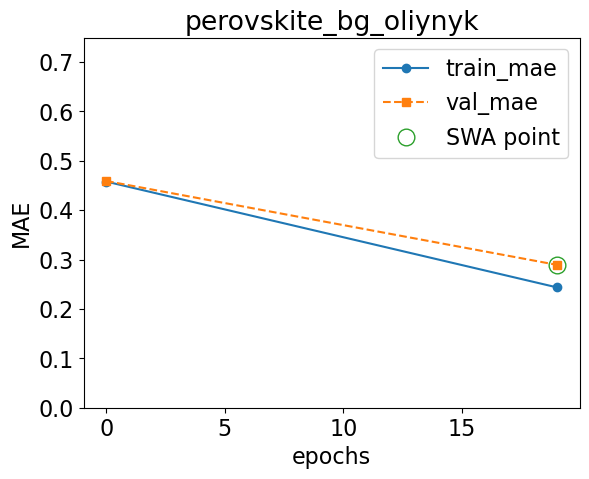

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


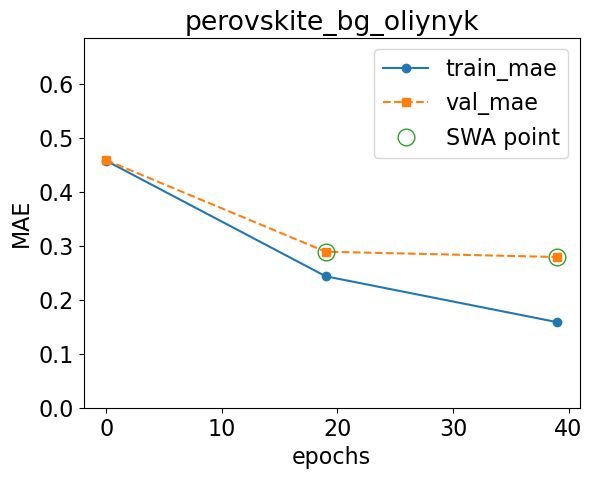

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


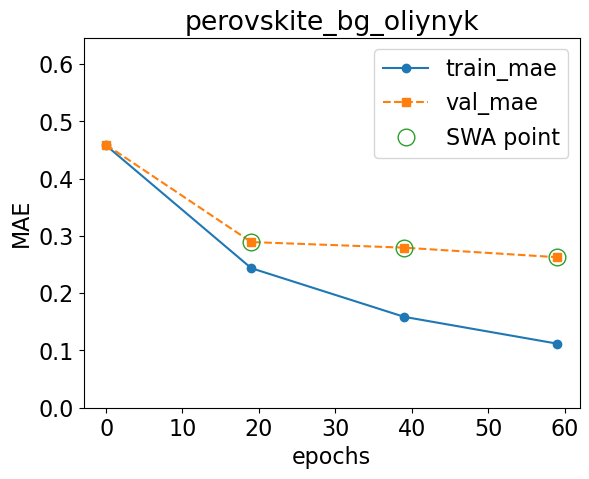

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


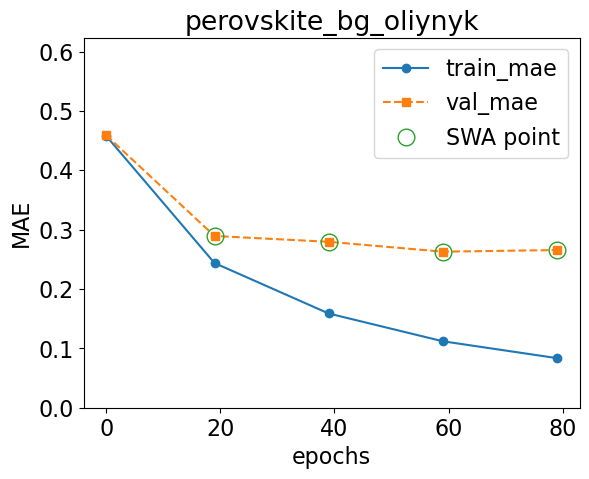

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


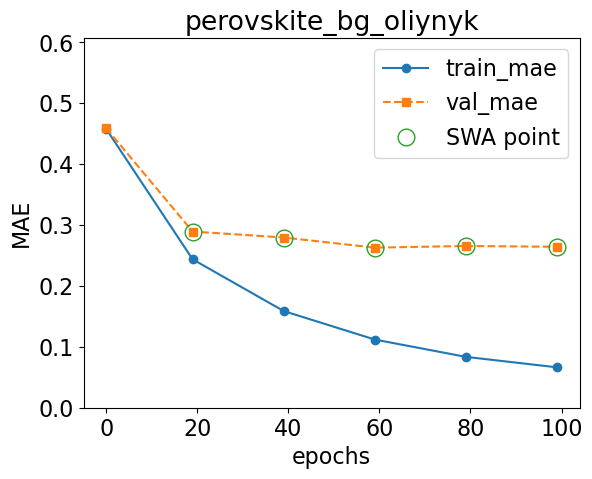

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


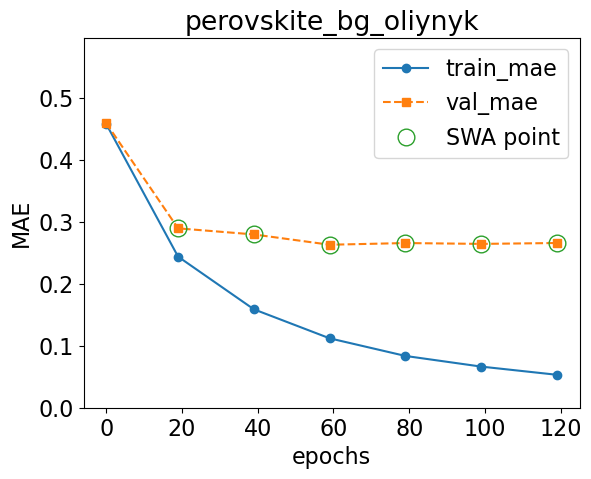

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


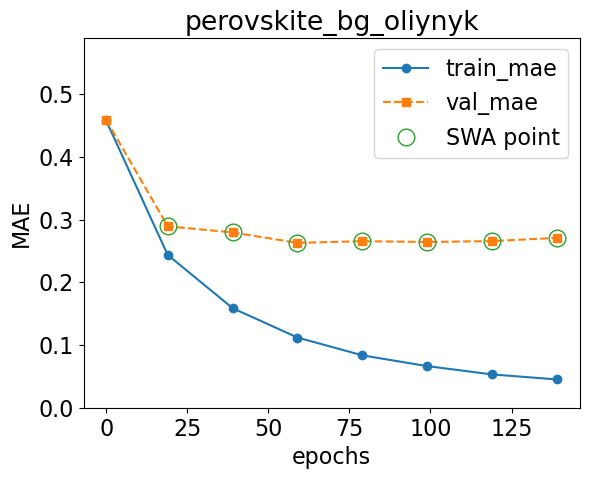

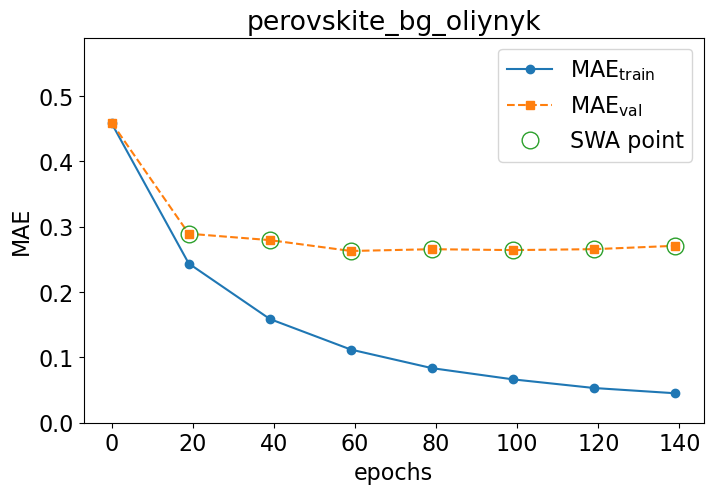

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_oliynyk) to models/trained_models/perovskite_bg_oliynyk.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 79493.15formulae/s]

skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])


loading data with up to 9 elements in the formula


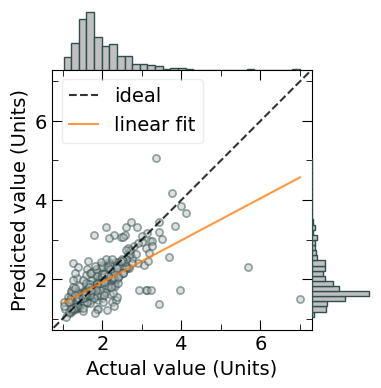

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[3]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_oliynyk', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_oliynyk.pth')

2026-02-08 22:21:23.927 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 31180.74formulae/s]

skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 130711.91formulae/s]


skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler
Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


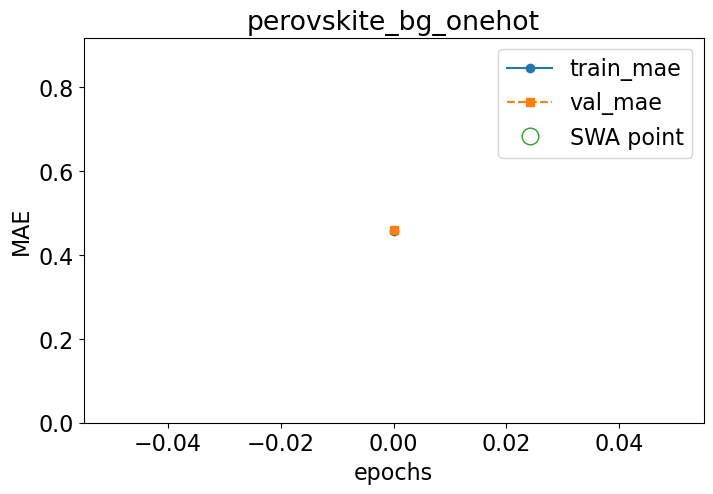

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


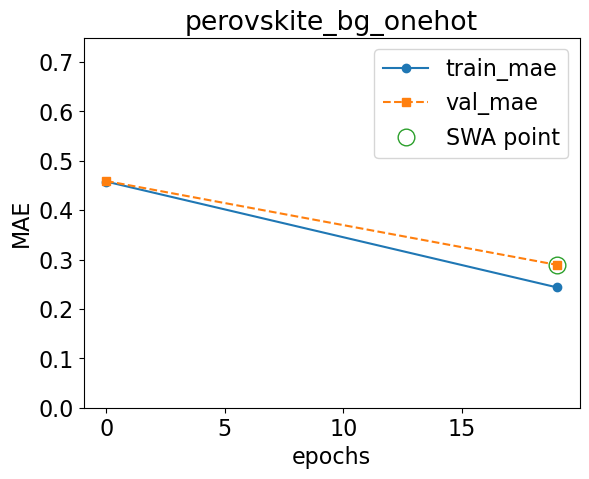

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


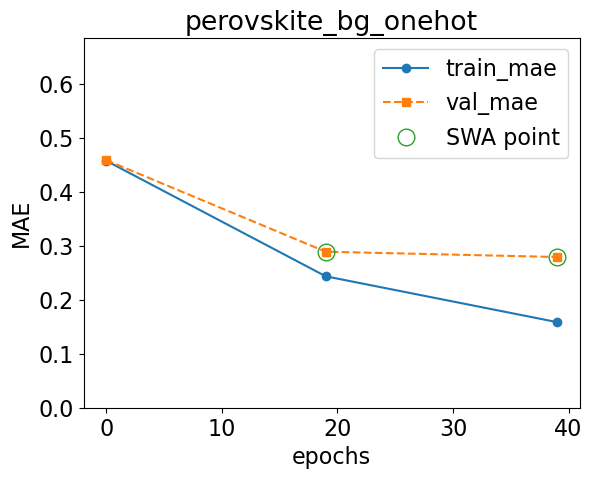

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


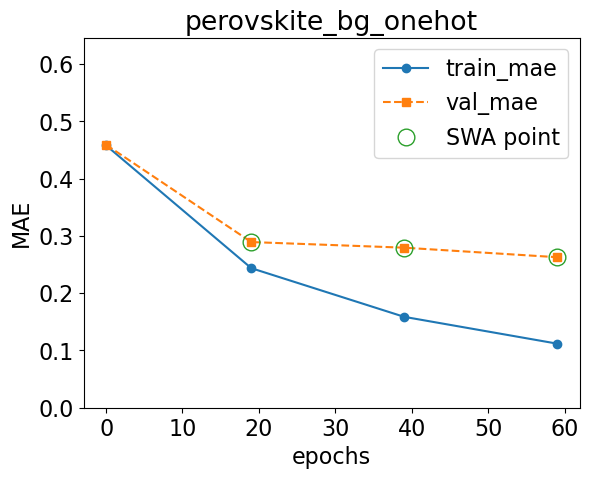

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


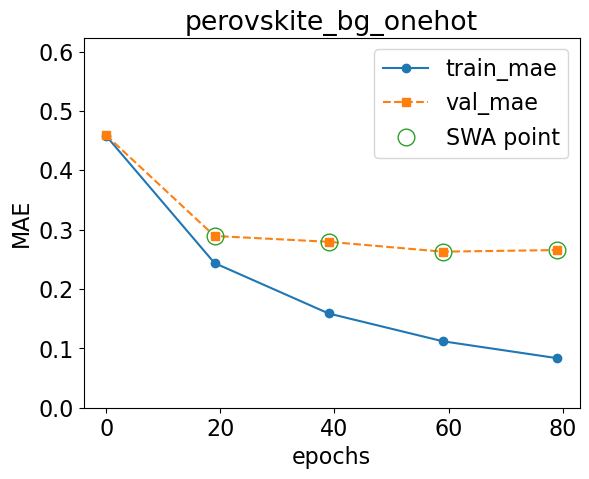

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


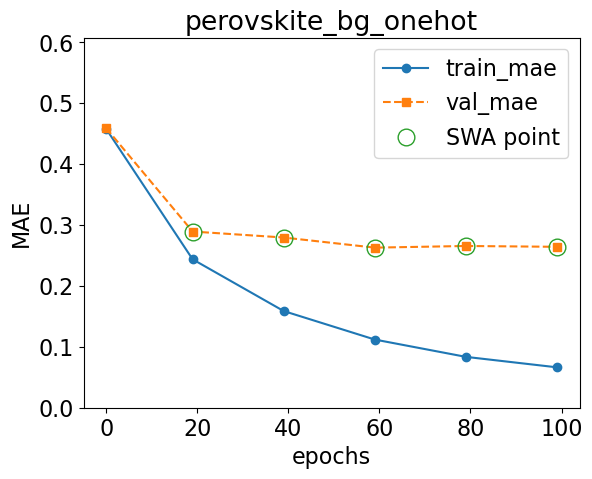

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


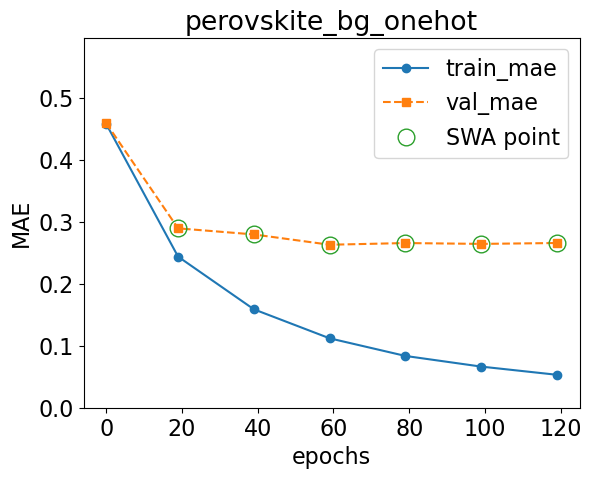

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


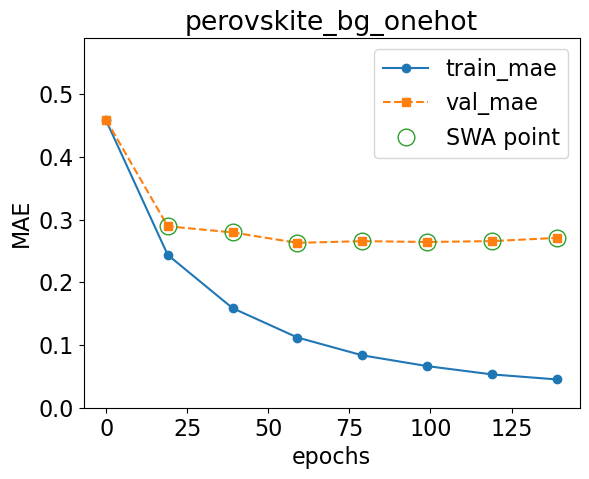

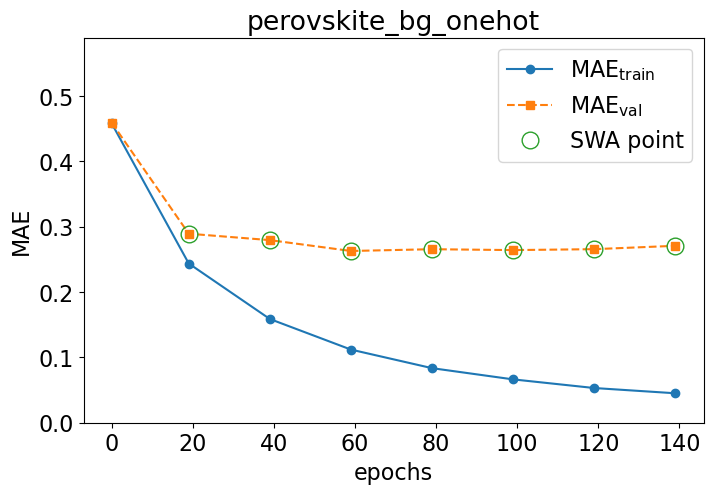

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_onehot) to models/trained_models/perovskite_bg_onehot.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 63757.64formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


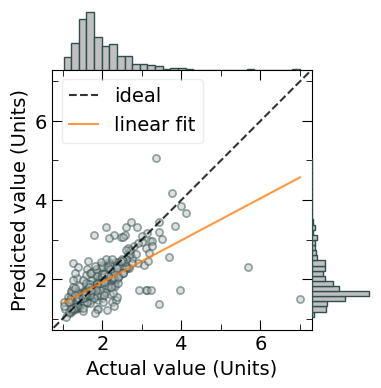

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[4]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_onehot', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_onehot.pth')

2026-02-08 22:25:52.506 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 53736.81formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 130153.22formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


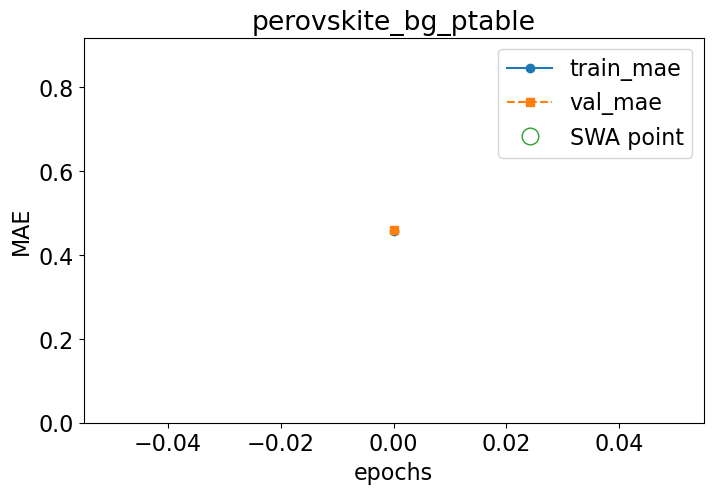

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


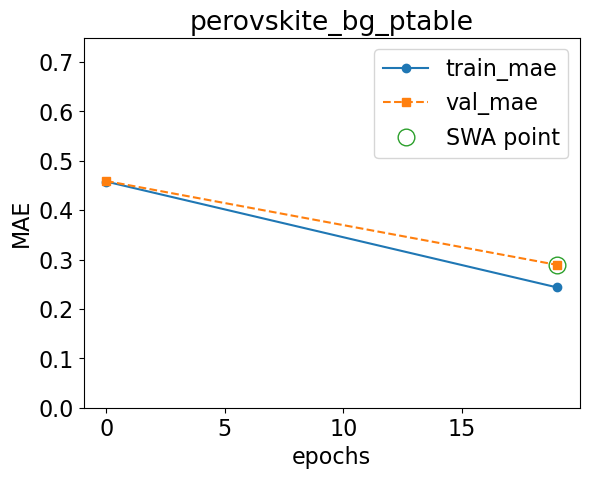

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


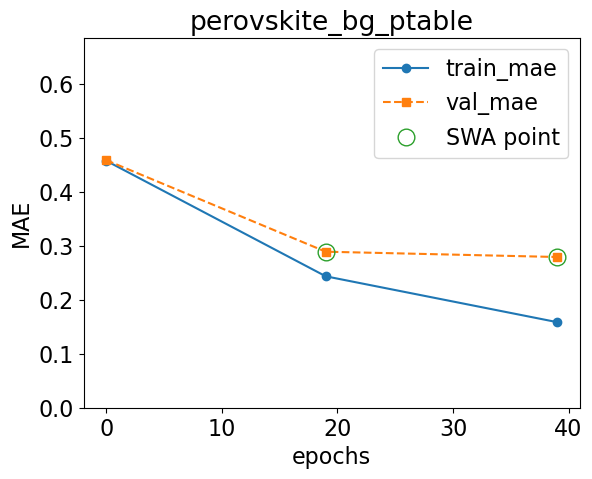

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


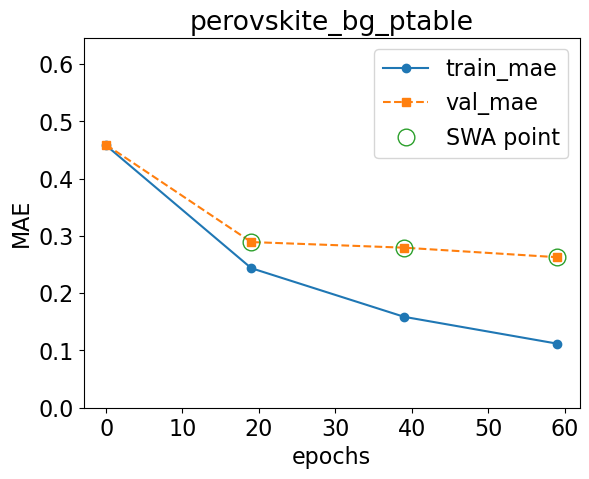

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


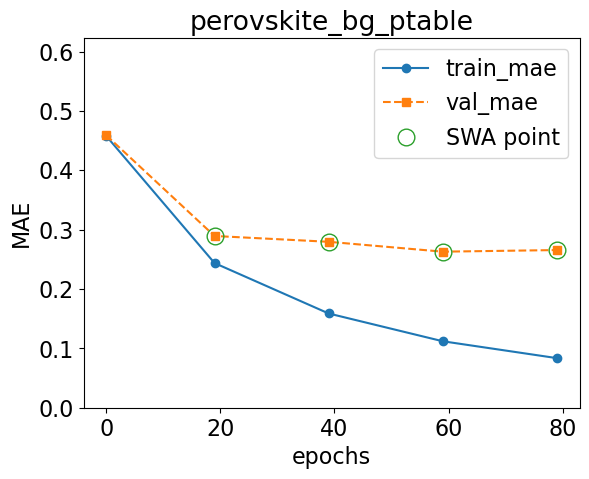

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


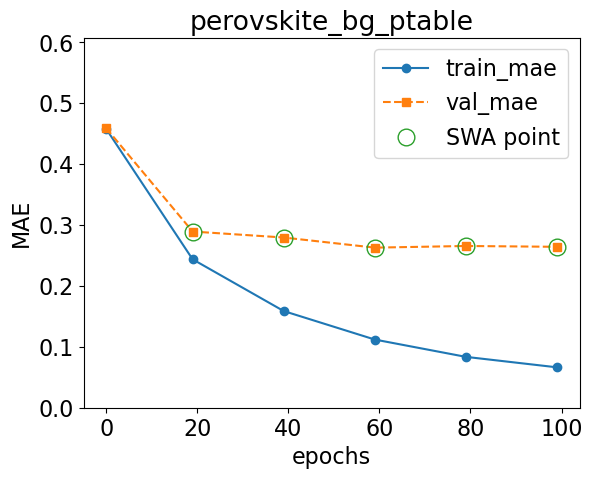

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


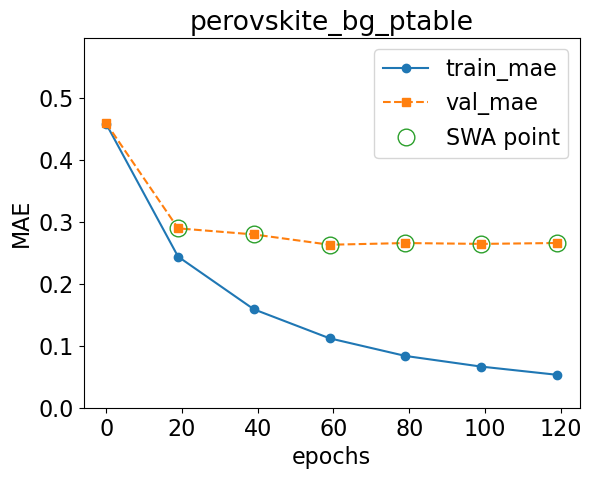

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


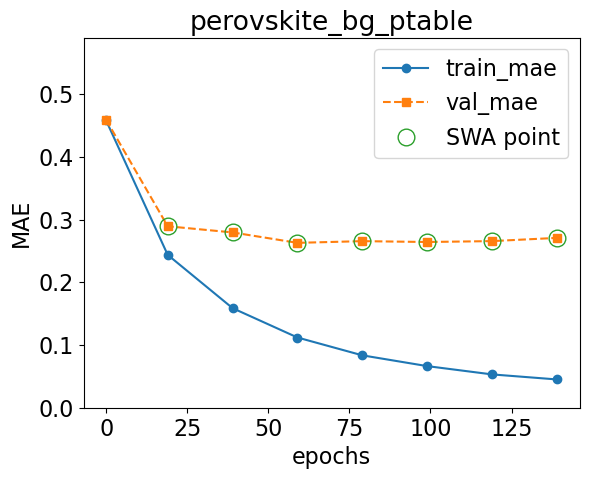

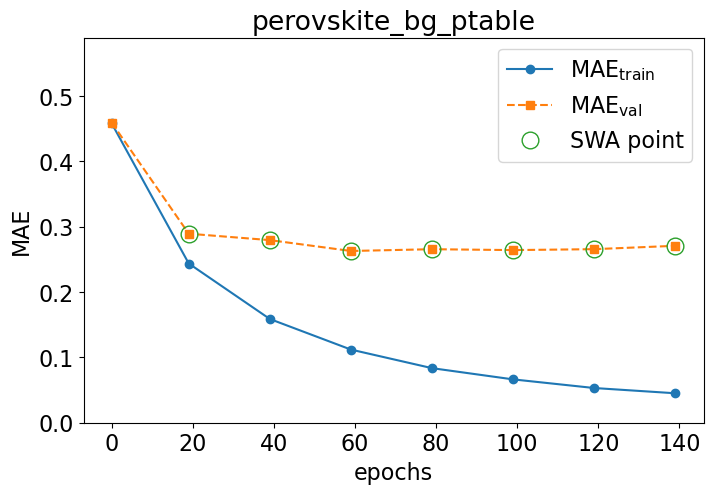

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_ptable) to models/trained_models/perovskite_bg_ptable.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 80310.81formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


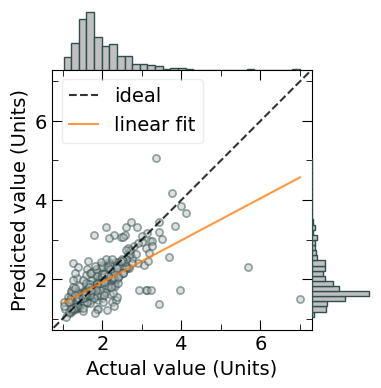

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[5]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_ptable', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_ptable.pth')

2026-02-08 22:30:23.415 | INFO     | tf_chpvk_pv.config:<module>:11 - PROJ_ROOT path is: /home/dagar/TF-ChPVK-PV


The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 80221.12formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 49052.24formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.458 val mae: 0.459


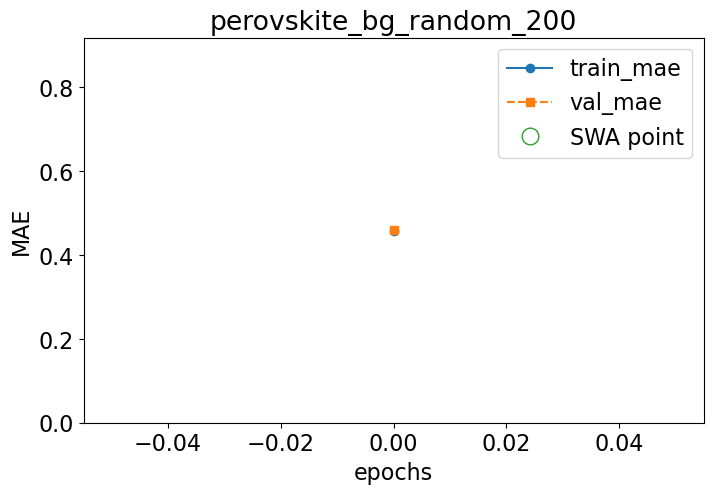

Epoch: 19/300 --- train mae: 0.244 val mae: 0.289


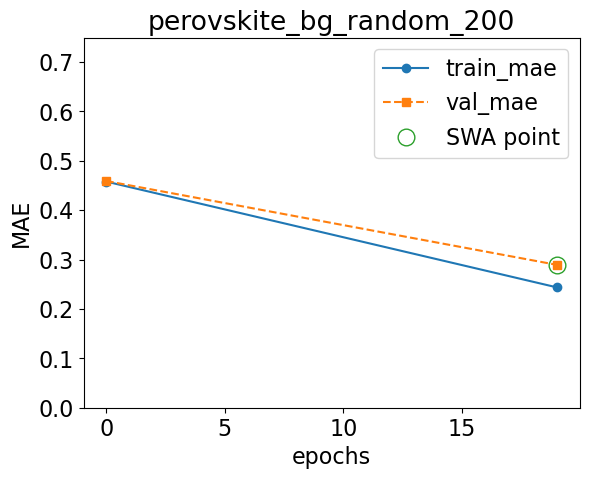

Epoch: 39/300 --- train mae: 0.159 val mae: 0.279


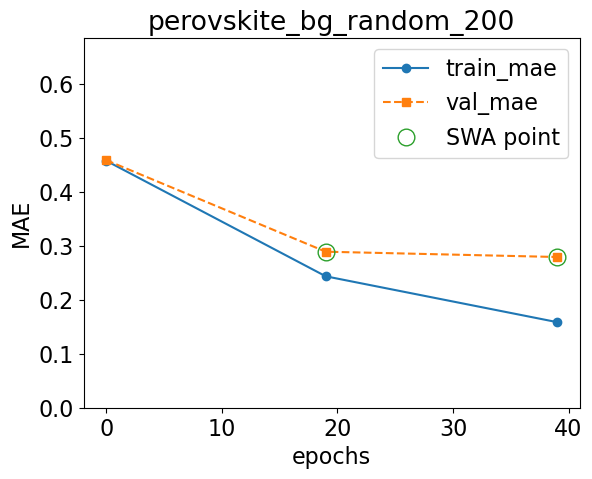

Epoch: 59/300 --- train mae: 0.112 val mae: 0.263


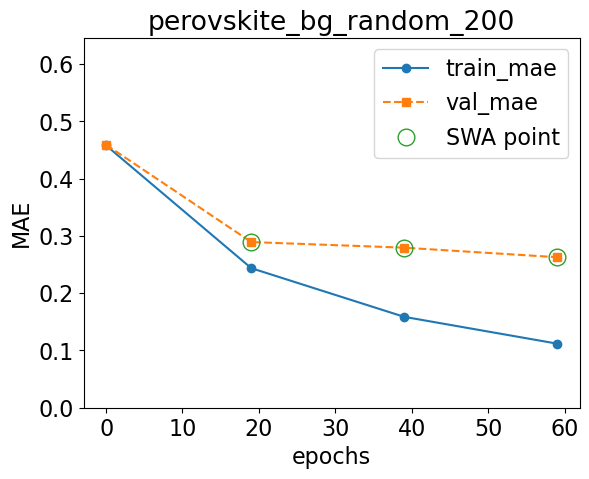

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0835 val mae: 0.266


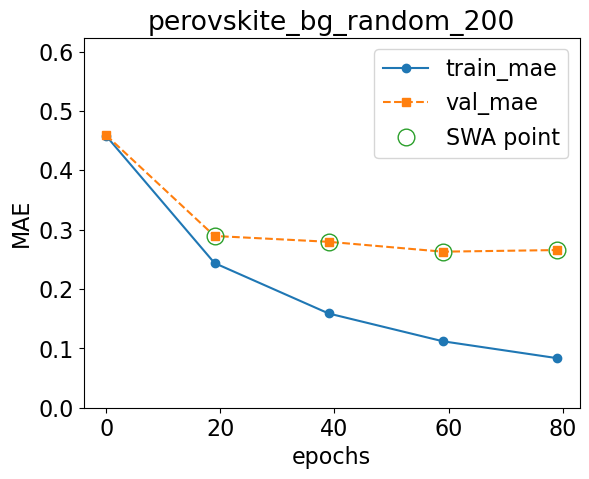

Epoch: 99/300 --- train mae: 0.0663 val mae: 0.264


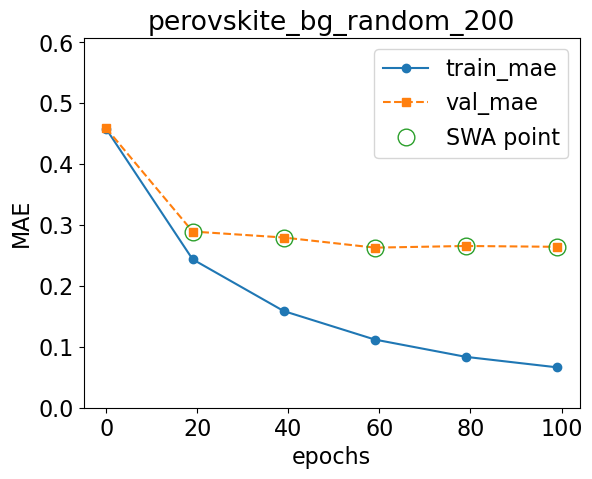

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 0.0531 val mae: 0.266


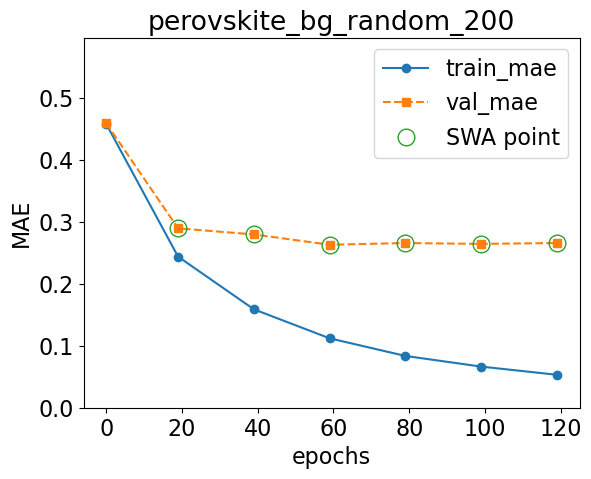

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 0.0451 val mae: 0.271


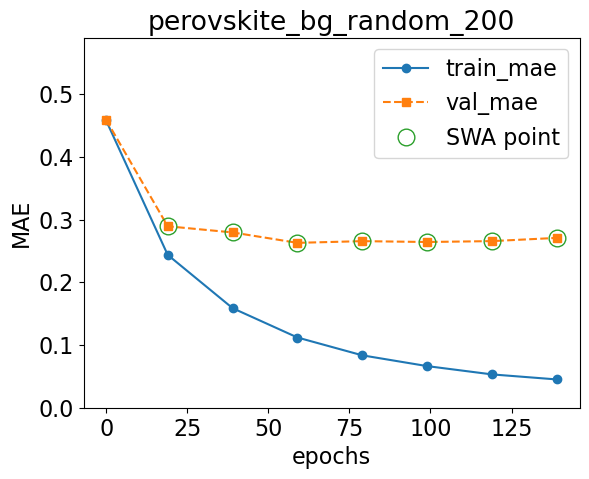

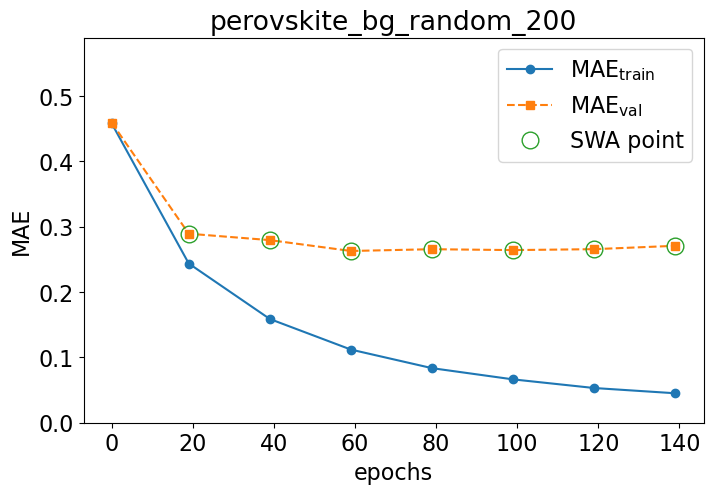

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_random_200) to models/trained_models/perovskite_bg_random_200.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 17662.38formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


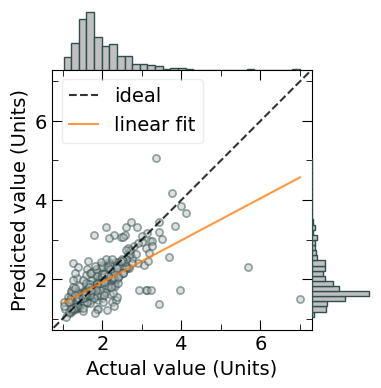

R2 score: 0.3900415190134503
MSE: 0.2637437054753685
MAE: 0.24881896238977197 eV


In [1]:
possible_encoders = ["jarvis", "magpie", "mat2vec", "oliynyk", "onehot", "ptable", "random_200"]

encoder = possible_encoders[6]

from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_random_200', elem_prop=encoder, learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df, model_path = TRAINED_MODELS / 'perovskite_bg_random_200.pth')

## Train without petifor

The data comes from the following sources:
74.16 % from halide perovskites,
0.0247 % from chalcogenides perovskites,
25.82 % from chalcogenide semiconductors
The shape of the DataFrame is:  (3628, 3)

Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 2902/2902 [00:00<00:00, 57567.09formulae/s]


skipping composition OrderedDict([('H', 14.0), ('C', 5.0), ('N', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 595.0), ('I', 300.0), ('N', 198.0), ('Pb', 100.0), ('C', 99.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 271.0), ('C', 109.0), ('N', 20.0), ('F', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 13.0), ('C', 2.0), ('N', 2.0), ('P', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 30.0), ('I', 13.0), ('C', 7.0), ('N', 4.0), ('Pb', 4.0), ('B', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 558.0), ('I', 300.0), ('Pb', 100.0), ('C', 93.0), ('N', 93.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 24.0), ('I', 13.0), ('C', 4.0), ('N', 4.0), ('Pb', 4.0), ('Ac', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('I', 9.0), ('Ga', 1.0), ('In', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 5.0), ('I', 3.0), ('N', 2.0), ('C', 1.0), ('Sn

Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 127089.51formulae/s]

skipping composition OrderedDict([('H', 585.0), ('I', 300.0), ('N', 194.0), ('Pb', 100.0), ('C', 97.0), ('S', 3.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 145.0), ('I', 75.0), ('N', 48.0), ('Pb', 25.0), ('C', 24.0), ('S', 1.0), ('X', 1.0)])
loading data with up to 9 elements in the formula
stepping every 120 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 0.453 val mae: 0.454


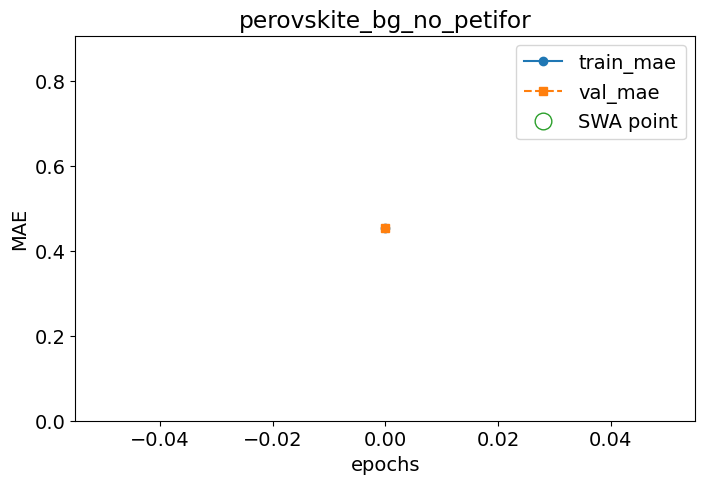

Epoch: 19/300 --- train mae: 0.246 val mae: 0.292


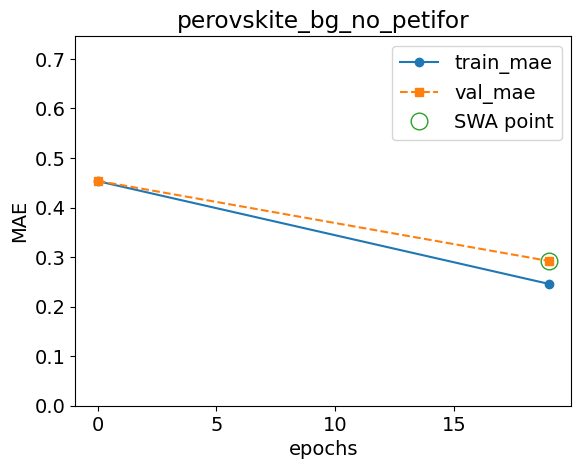

Epoch: 39/300 --- train mae: 0.162 val mae: 0.277


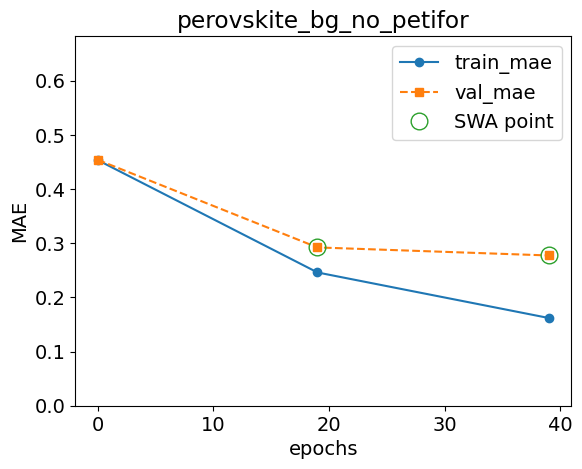

Epoch: 59/300 --- train mae: 0.11 val mae: 0.271


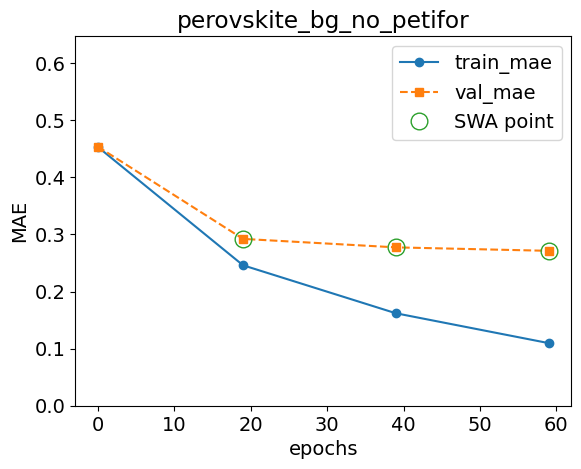

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 0.0824 val mae: 0.276


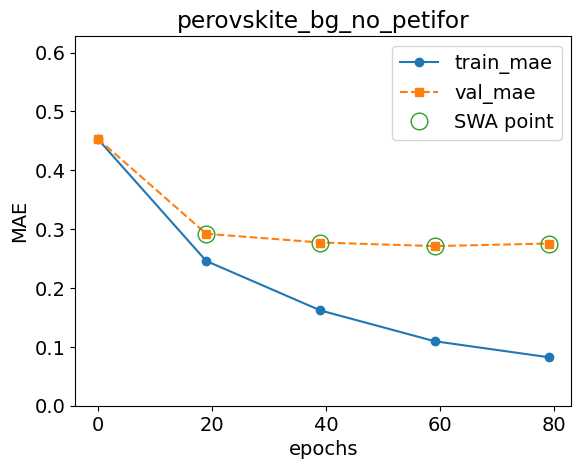

Epoch 99 failed to improve.
Discarded: 2/3 weight updates
Epoch: 99/300 --- train mae: 0.0632 val mae: 0.274


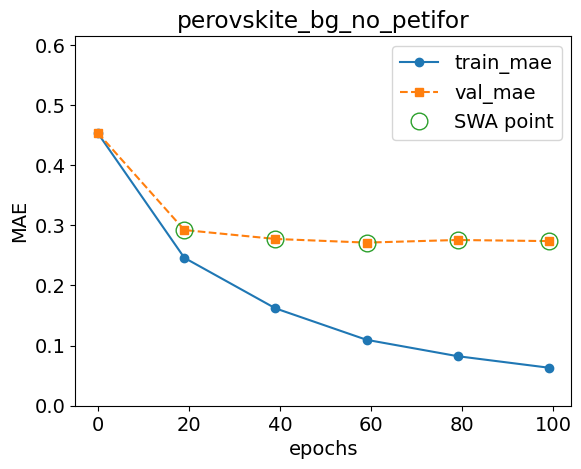

Epoch 119 failed to improve.
Discarded: 3/3 weight updates
Epoch: 119/300 --- train mae: 0.0508 val mae: 0.273


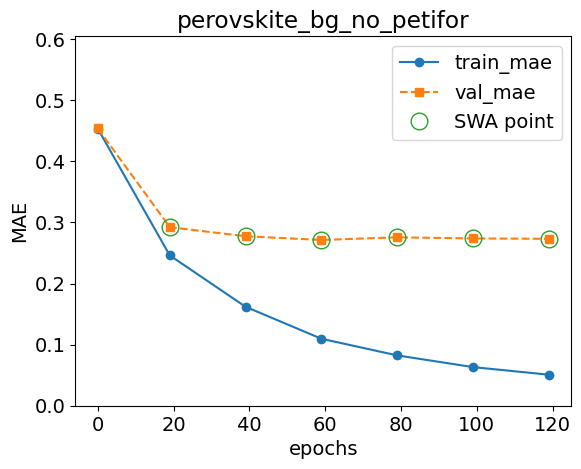

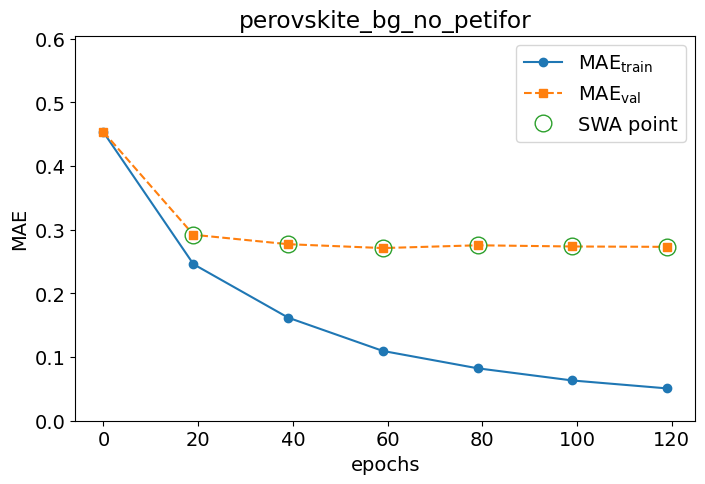

Discarded: 3/3weight updates, early-stopping now
Saving network (perovskite_bg_no_petifor) to models/trained_models/perovskite_bg_no_petifor.pth


/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dagar/anaconda3/envs/env-tf-chpvk/lib/python3.8/site-packages/crabnet/crabnet_.py:1128: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpic


Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cuda:0
No feature names provided, using only formula and target columns.


Generating EDM: 100%|██████████| 363/363 [00:00<00:00, 94227.77formulae/s]


skipping composition OrderedDict([('H', 115.0), ('I', 60.0), ('N', 38.0), ('Pb', 20.0), ('C', 19.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 295.0), ('I', 150.0), ('N', 98.0), ('Pb', 50.0), ('C', 49.0), ('S', 1.0), ('X', 1.0)])
skipping composition OrderedDict([('H', 102.0), ('I', 60.0), ('Pb', 20.0), ('C', 17.0), ('N', 17.0), ('X', 1.0)])
loading data with up to 9 elements in the formula


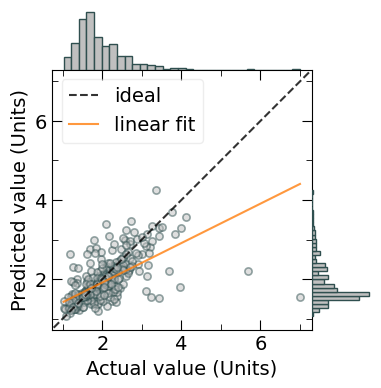

R2 score: 0.376409781419079
MSE: 0.2696380164773114
MAE: 0.25837495422058776 eV


In [2]:
from tf_chpvk_pv.modeling.CrabNet.utils import test_r2_score
from tf_chpvk_pv.config import TRAINED_MODELS
from crabnet.utils.data import groupby_formula  # type: ignore

from tf_chpvk_pv.modeling.CrabNet.utils import get_raw_data

df = get_raw_data()

df_new = df.copy()
 
# Rename the column 'bandgap' to 'target', and 'reduced_formula' to 'formula'
df_new.rename(columns={'bandgap': 'target'}, inplace=True)
df_new.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

# Group repeated formulas and take the median of the target
df_grouped_formula = groupby_formula(df_new, how='median')
print('The shape of the DataFrame is: ', df_grouped_formula.shape)

from tf_chpvk_pv.modeling.CrabNet.utils import get_petiffor_features

train_df, val_df, test_df, feature_names = get_petiffor_features(df_grouped_formula, original_df=df_new)
train_df.drop(columns=feature_names, inplace=True)
val_df.drop(columns=feature_names, inplace=True)
test_df.drop(columns=feature_names, inplace=True)
from crabnet.crabnet_ import CrabNet  # type: ignore

crabnet_bandgap = CrabNet(mat_prop="bandgap", model_name='perovskite_bg_no_petifor', elem_prop='mat2vec', learningcurve=True,)
crabnet_bandgap.fit(train_df, val_df)

test_r2_score(test_df,model_path = TRAINED_MODELS / 'perovskite_bg_no_petifor.pth')